__Function Definition__

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov  9 12:00:31 2018

@author: Hansheng 
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display
import scipy.linalg
from itertools import combinations
from numpy import linalg
from numpy.linalg import matrix_rank
from scipy.sparse.linalg import svds, eigs
import random
import time
from scipy.optimize import minimize
import math
import matplotlib.mlab as mlab
from scipy import integrate
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import scipy.stats
import csv
import statistics as stats
import pandas as pd
import colorsys
from scipy.integrate import quad
from scipy.integrate import dblquad

from sympy import sin, cos, symbols

np.random.seed(26)


def lmo(beta,X,y,sigma,f):
    #return the objective funciton of the linear oprimization problem
    n = len(X)
    p = len(X[0])
    obj = 0
    for i in range(n):
        obj = obj - np.exp(-0.5*(y[i] - np.dot(X[i],beta))**2 /(sigma**2))/f[i]
    return obj  

def jacobian(beta,X,y,sigma,f):
    #return gradient of the linear objective function
    n = len(X)
    p = len(X[0])
    jac = np.zeros((p,1))
    for i in range(n):
        temp = (y[i] - np.dot(X[i],beta))**2 /(sigma**2)
        jac = jac - np.exp(-0.5*temp)*temp/f[i]/(sigma**2) * np.reshape(X[i],(p,1))
        jac = np.reshape(jac,(p,1))
    jac = np.reshape(jac, (p,))
    return jac

def hessian(beta,X,y,sigma,f):
    #return Hessian of the linear objetive function
    n = len(X)
    p = len(X[0])
    hess = np.zeros((p,p))
    for i in range(n):
        temp = (y[i] - np.dot(X[i],beta))**2 /(sigma**2)
        x1 = np.reshape(X[i],(p,1))
        x2 = np.reshape(X[i],(1,p))
        temp2 = np.matmul(x1,x2)
        hess = hess - (np.exp(-0.5*temp)*temp**2/(sigma** 4) -np.exp(-0.5*temp)/(sigma**2))/f[i]*temp2
    return hess


#===============================================================================================
def sollmo(X,y,sigma,f):
    '''solve linear minimization oracle
    this is an nonconvex problem with respect to beta, the result is approximal
    return a new supporting vector g and corresponding beta
    
    '''
    n = len(X)
    p = len(X[0])
    
    #nonconvex algorithms are sensitive to initialization!!!!
    #initialize beta0 with OLS solution or 0 or random
    beta0 = np.reshape(np.dot( np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)) 
    #beta0 = np.zeros((p,1))
    #beta0 = np.reshape(np.random.uniform(-10,10,p),(p,1))
    
    #minimize exponential sum approximately
    #nonconvex problem
    
    #OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),jac = jacobian, method = 'BFGS')
    OptResult = minimize(lmo, beta0, args = (X,y,sigma,f),method = 'Powell')
   
    beta_sol = OptResult.x
    
    g = np.zeros((n,1))
    for i in range(n):
        g[i] = 1/(np.sqrt(2*np.pi)*sigma)* np.exp(-0.5*(y[i] - np.dot(X[i],beta_sol))**2 /(sigma**2))
    return g,beta_sol
#===========================================================================================================



def FW_FC(f,alpha,P,n):
    #solve the fully corective step using classic FW
    #warm start with f from last iteration
    #P each column of P is a candidate component
    #return new f, and f as a convex combination of columns of P with coefficients alpha
    iter = 5000
    
    k = len(P[0])
    alpha = np.append(alpha,0)
    alpha = np.reshape(alpha,(k,1))
    for t in range(1,iter):
        g = 1/f
        g = np.reshape(g,(1,n))
        s = np.argmax(np.matmul(g,P))
        gamma = 2/(t+2)
        f = (1-gamma)*f +gamma*np.reshape(P[:,s],(n,1))
        temp = np.zeros((k,1))
        temp[s] = 1
        alpha = (1-gamma)*np.reshape(alpha,(k,1))+gamma*temp
    return f,alpha

def NPMLE_FW(X,y,iter,sigma):
    '''
    Use FW algorithm to solve NPMLE problem of MLR  
    sigma is estimated before
    
    Input
    X: covariate matrix
    y: response variable
    iter: number of iterations
    sigma: std of noise
    
    Output
    f: n * J, atomic likelihood vectors in active set
    B: p * J, coefficients corresponding to vectors in active set
    alpha: J * 1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    
    L_rec = []
    
    #initialize beta0 and f
    beta0 = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)) #beta0 is OLS solution
    #beta0 = np.zeros((p,1))
    f = np.zeros((n,1))
    for i in range(n):
        f[i] = 1/(np.sqrt(2*np.pi)*sigma)* np.exp(-0.5*(y[i] - np.dot(X[i],beta0))**2 /(sigma**2))
    
    # initialize P,B
    # P active set
    # B beta's corresponding to columns of P
    P = np.zeros((n,1))
    P[:,0] = f.ravel()
    B = np.zeros((p,1))
    B[:,0] = beta0.ravel()
    
    # intialize coefficients of convex combinations
    alpha = np.array([1]) 
    
    for t in range(1,iter):
        #solve LMO
        g, beta_sol = sollmo(X,y,sigma,f)
        print("beta_sol",beta_sol)
        
        g = np.reshape(g,(n,1))
        beta_sol = np.reshape(beta_sol,(p,1))
        P = np.append(P,g,axis = 1)
        B = np.append(B,beta_sol,axis = 1)
        
        #fully corrective step wrt current active set P
        f, alpha = FW_FC(f,alpha,P,n)
        
        #prune P by deleting columns corresponding to zero alpha
        P_prune = np.zeros((n,1))
        B_prune = np.zeros((p,1))
        alpha_prune = np.zeros((1,))
        flag = 0
        for i in range(len(P[0])):
            if alpha[i] > 0:
                if flag == 0:
                    P_prune[:,0] = P[:,i].ravel()
                    B_prune[:,0] = B[:,i].ravel()
                    alpha_prune[0] = alpha[i]
                    flag = 1
                else:
                    P_prune = np.append(P_prune,np.reshape(P[:,i],(n,1)), axis = 1)
                    alpha_prune = np.append(alpha_prune, alpha[i])
                    B_prune = np.append(B_prune,np.reshape(B[:,i],(p,1)),axis = 1)
        
        P = P_prune
        B = B_prune
        alpha = np.reshape(alpha_prune/np.sum(alpha_prune), (len(P[0]),1))
        
        #record the change of neg-log likelihood function
        temp = np.sum(np.log(1/f))
        L_rec.append(temp)
    return f, B, alpha, L_rec, temp


def train_error(X,y,B,alpha):
    beta_ave = np.matmul(B,alpha)
    y = np.reshape(y,(len(y),1))
    y_train = np.zeros((len(y), 1))
    for i in range(len(y)):
        y_train[i] = np.matmul(X[i],beta_ave)
    y_train = np.reshape(y_train, (len(y),1))
    return linalg.norm(y - y_train)**2/len(X)


In [2]:
def L_sigma_rec_synthetic(n,iter, b1, b2,sigma):    
    '''
    return the neg-log likelihood as a function of sigma
    synthesize its own data
    test on a list of sigma
    '''
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    probthre = 1e-2
    pi = 0.5 # first componrnt has probability pi
    
    sigma1 = 2*sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
        else:
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
    
    
    sigma_list = np.arange(sigma2/2,sigma1*2,0.2)
    
    
    L_sigma_rec = []
    for sigma_est in sigma_list:
        f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
        L_sigma_rec.append(L_final)
        
    fig = plt.figure(figsize = (6,5))
    plt.plot(L_sigma_rec);
    plt.title("final likelihood over different sigma");
    return L_sigma_rec    

In [3]:
#test function with synthetic data
def test(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est):
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1))
    
    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            C[i] = 2
        else:
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            C[i] = 3
            
            
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run Frank-Wofle
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig0 = plt.figure(figsize = (8,8))
    for i in range(len(y)):
        if C[i] == 1:
            plt.scatter(X[i][1],y[i],color = 'red',marker = 'o',label = 'Class 1', facecolors = 'None');
        elif C[i] == 2:
            plt.scatter(X[i][1],y[i],color = 'blue',marker = 'o',label = 'Class 2', facecolors = 'None');
        else:
            plt.scatter(X[i][1],y[i],color = 'green',marker = 'o',label = 'Class 3', facecolors = 'None');
            
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    i = 0
    plt.plot(t,b1[0]+b1[1]*t, color = 'red',linewidth = pi1*8 )
    plt.plot(t,b2[0]+b2[1]*t, color = 'blue',linewidth = pi2*8 )
    if pi1 + pi2 < 1:
        plt.plot(t,b3[0]+b3[1]*t, color = 'green',linewidth = (1-pi2-pi2)*8 )
           
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    if pi1 + pi2 <1:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi2),Line2D([], [], color='blue')),
                         (Line2D([], [], color='green', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*(1-pi1-pi2)),Line2D([], [], color='green'))
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                  'y = %.1f + %.1f x with probility %.2f' %(b3[0], b3[1], 1-pi1-pi2),
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc = 2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    else:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi2),Line2D([], [], color='blue')),
                    
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc=2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.show();

    
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sort = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sort:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,b[0]+b[1]*t, color = tuple( np.array(RGB_tuples[temp])/255),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with probility %.2f' %(b[0], b[1], alpha[i]))
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    
    #custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    #Line2D([0], [0], color= 'red'# ),
                    #Line2D([0], [0], color='black')
                    #,Line2D([0], [0], color='green')#
                    #,]
    #plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                            #  , 'NPMLE component'#, 'OLS'#
                            # ],loc=0);
    plt.legend(bbox_to_anchor=(0., -0.05), loc=2, borderaxespad=0.)
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.show();

    
    #plot Hellinger distance
    fig2 = plt.figure(figsize = (20,3))
    x_list = [-3,-1,1,3,5] #List of x values
    i = 0
    
    for i in range(len(x_list)):
        x = x_list[i]
        y = np.linspace(- 15, 15, 100)
           
        #calculate difference of suqre root of density functions
        dist_fit = lambda y: (np.sqrt(0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x), 0, sigma)+0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x),0, sigma)) \
        - np.sqrt(sum(alpha[i]*scipy.stats.norm.pdf( y - (B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha)))))**2
        
        print("Fix x = %.1f, squared Hellinger distance for NPMLE is %.5f" % (x, quad(dist_fit, -np.inf, np.inf)[0]))

        
        plt.subplot(1,len(x_list),i+1)
        plt.plot(y,pi1*scipy.stats.norm.pdf(y - (b1[0]+b1[1]*x), 0, sigma)+pi2*scipy.stats.norm.pdf(y-(b2[0]+b2[1]*x),0, sigma)+(1-pi1-pi2)*scipy.stats.norm.pdf(y-(b3[0]+b3[1]*x),0, sigma),'red',label = 'True distribution')
        plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-(B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha))),'black',label = 'NPMLE distribution')
        plt.title("x = %.1f"%x)
    custom_lines = [
                Line2D([0], [0], color= 'red'),
                Line2D([0], [0], color='black'),
                #Line2D([0], [0], color='green')#
        ]
    plt.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    fig3 = plt.figure(figsize = (6,5))
    plt.plot(L_rec);plt.title("neg-log likelihood over iterations");
      
    

In [4]:
def test_EB(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est):
    '''
    plot Empirical Bayes results on 2/3 components
    
    
    '''
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    y_true = np.zeros((n,1))
    y_EB = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1))
    
    # set random seed
    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            y_true[i] = np.dot(X[i],b1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            y_true[i] = np.dot(X[i],b2)
            C[i] = 2
        else:
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            y_true[i] = np.dot(X[i],b3)
            C[i] = 3
            
            
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run Frank-Wofle
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    # calculate Empirical Bayes estimator
    N = len(B[0])
    temp0 = 0
    for i in range(n):
        temp1 = 0
        temp2 = 0
        for j in range(N):
            temp0 = np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2/(sigma**2))
            temp1 = temp1 + np.dot(X[i],B[:,j])*temp0
            temp2 = temp2 + temp0
        y_EB[i] = temp1/temp2          
        
    
    #plot
    fig = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y,color = 'grey',s = 2,marker = 'o', label = 'Noisy data', facecolors = 'None');
    plt.scatter(X[:,1],y_true,color = 'red',s = 2, marker = 'o',label = 'True data', facecolors = 'None');
    plt.scatter(X[:,1],y_EB,color = 'green',s = 2, marker = 'o',label = 'Empirical Bayes', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig1 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y,color = 'grey',s = 2,marker = 'o', label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig2 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y_true,color = 'red',s = 2, marker = 'o',label = 'True data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig3 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y_EB,color = 'green',s = 2, marker = 'o',label = 'Empirical Bayes', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();

__Synthetic Data__

beta_sol [6.65852709 0.84739606]
beta_sol [4.437518   0.65457734]
beta_sol [ 4.43528705 -1.44238964]
beta_sol [0.29525042 1.99568489]
beta_sol [0.32619113 1.29404271]
beta_sol [0.9426797  1.54759374]
beta_sol [0.79071424 1.15394887]
beta_sol [0.75883027 0.66736781]
beta_sol [0.89552965 0.8481905 ]
beta_sol [1.04892431 1.09581304]
beta_sol [0.90831409 0.99359094]
beta_sol [0.97166508 1.35331147]
beta_sol [0.95727491 1.10072293]
beta_sol [0.95556876 0.99719384]
beta_sol [0.93684432 1.03125671]
beta_sol [0.92895445 0.98962186]
beta_sol [0.92497442 1.01633417]
beta_sol [0.92081624 1.00302994]
beta_sol [0.92478384 1.00472996]
beta_sol [0.92029164 1.00121502]
beta_sol [0.92098965 1.00386828]
beta_sol [0.92033979 1.00128725]
beta_sol [0.92099215 1.00363185]
beta_sol [0.92003421 1.00053747]
beta_sol [0.92030223 1.00116491]
beta_sol [0.92040896 1.00127868]
beta_sol [0.91995767 1.00021302]
beta_sol [0.91953581 0.99894566]
beta_sol [0.92070001 1.00279819]
beta_sol [0.92084724 1.00243971]
beta_sol

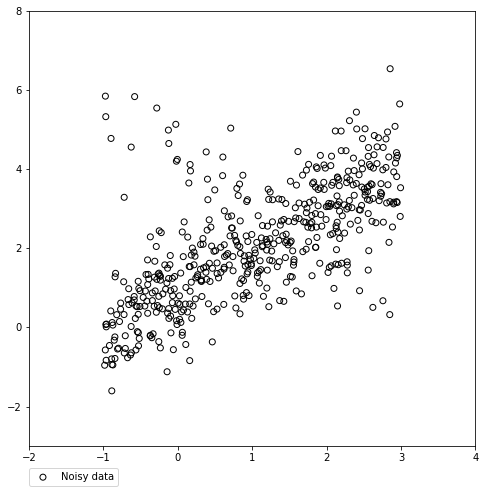

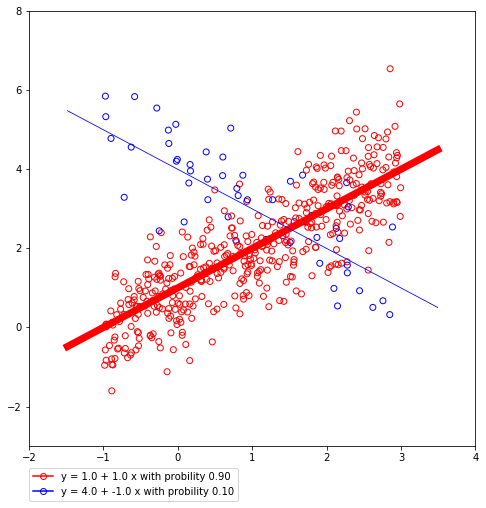

coefficients [0.92497442 1.01633417] with probability [0.2244049]
coefficients [0.92478384 1.00472996] with probability [0.21325441]
coefficients [0.91953581 0.99894566] with probability [0.16422493]
coefficients [0.97166508 1.35331147] with probability [0.08673122]
coefficients [ 4.43528705 -1.44238964] with probability [0.08632234]
coefficients [0.93684432 1.03125671] with probability [0.0553147]
coefficients [0.92084724 1.00243971] with probability [0.04696277]
coefficients [0.92040896 1.00127868] with probability [0.02854389]
coefficients [0.91995767 1.00021302] with probability [0.02228442]
coefficients [0.92099215 1.00363185] with probability [0.0203009]


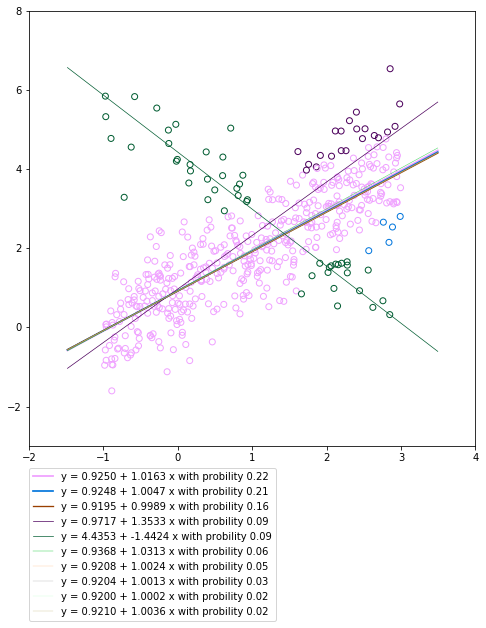

Fix x = -3.0, squared Hellinger distance for NPMLE is 0.10929
Fix x = -1.0, squared Hellinger distance for NPMLE is 0.09570
Fix x = 1.0, squared Hellinger distance for NPMLE is 0.00622
Fix x = 3.0, squared Hellinger distance for NPMLE is 0.08664
Fix x = 5.0, squared Hellinger distance for NPMLE is 0.11704


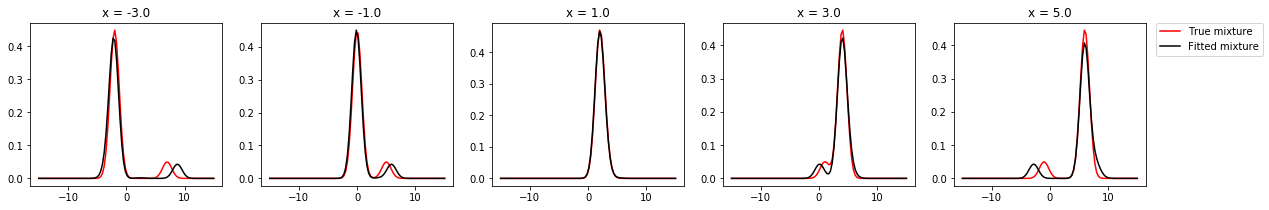

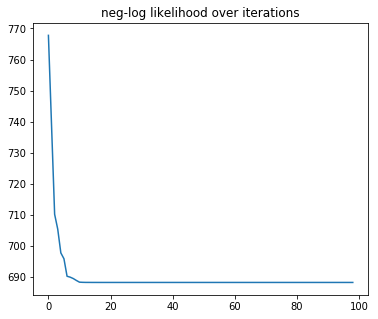

In [11]:
#colorful
test(500,100,(1,1),(4,-1),(-1,0.5),0.9,0.1,sigma = 0.8,sigma_est=0.8)

beta_sol [7.4036716  0.84947066]
beta_sol [-1.62930327  0.8472246 ]
beta_sol [0.96089962 2.7574585 ]
beta_sol [ 5.05676756 -0.92658412]
beta_sol [4.83180498 1.5190296 ]
beta_sol [-0.36461871  1.31547436]
beta_sol [5.21995411 0.5480638 ]
beta_sol [ 2.59404547 -0.65313618]
beta_sol [ 3.43074845 -0.58639482]
beta_sol [ 8.95428158 -2.88047576]
beta_sol [ 2.83052326 -0.55993699]
beta_sol [ 8.93465855 -2.85734669]
beta_sol [1.40993868 2.69178277]
beta_sol [4.54390457 1.15129395]
beta_sol [3.34956033 6.30100744]
beta_sol [ 4.54147209 -1.10531099]
beta_sol [0.05786603 0.50364447]
beta_sol [5.7626882  0.82855824]
beta_sol [ 4.47335301 -0.78236359]
beta_sol [ 4.58827468 -0.79233799]
beta_sol [0.05612725 0.87119306]
beta_sol [5.20931655 0.8822498 ]
beta_sol [ 4.64564697 -0.5262702 ]
beta_sol [1.5635221  3.11320642]
beta_sol [ 3.50255638 -0.4019439 ]
beta_sol [ 8.96950535 -2.7966766 ]
beta_sol [ 3.61140623 -0.4216287 ]
beta_sol [ 8.96899136 -2.79607268]
beta_sol [ 3.65812442 -0.43114405]
beta_sol 

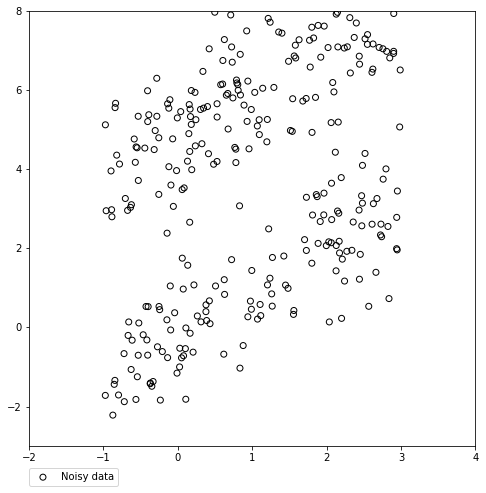

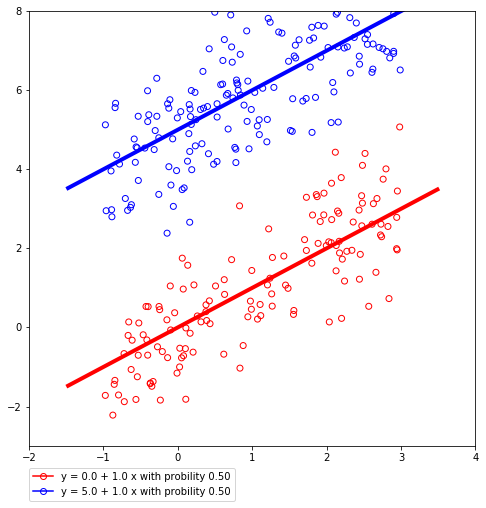

coefficients [4.80142603 0.97286878] with probability [0.22352539]
coefficients [-0.16292866  1.10128091] with probability [0.22336822]
coefficients [5.07355872 0.94196131] with probability [0.20876362]
coefficients [-0.16627123  1.19935296] with probability [0.1729843]
coefficients [5.07827809 0.97105435] with probability [0.0734402]
coefficients [-0.20219025  0.84906845] with probability [0.04598401]


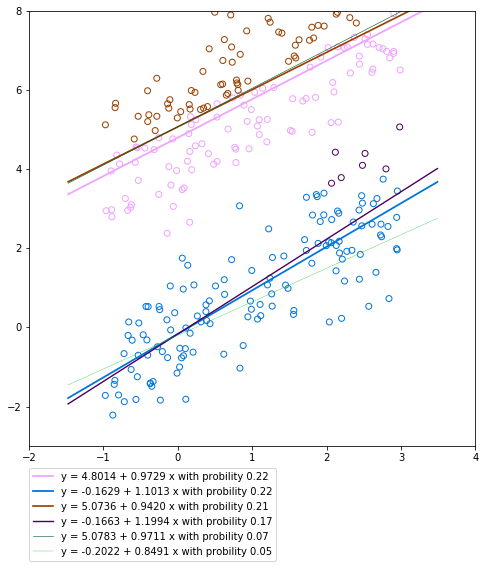

Fix x = -3.0, squared Hellinger distance for NPMLE is 0.67622
Fix x = -1.0, squared Hellinger distance for NPMLE is 0.64566
Fix x = 1.0, squared Hellinger distance for NPMLE is 0.61386
Fix x = 3.0, squared Hellinger distance for NPMLE is 0.60302
Fix x = 5.0, squared Hellinger distance for NPMLE is 0.65071


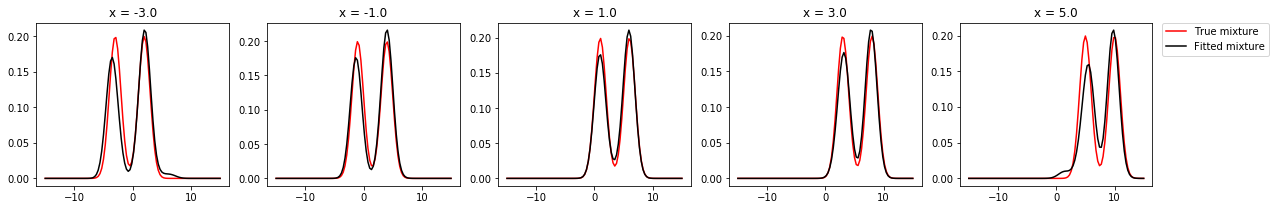

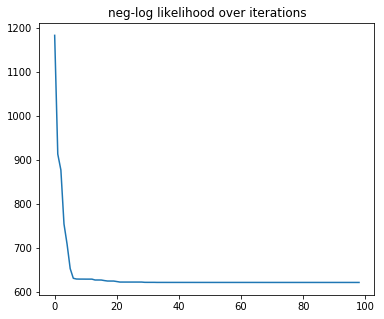

In [10]:
#colorful
test(300,100,(0,1),(5,1),(0,1),0.5,0.5,sigma = 1,sigma_est = 1)

beta_sol [ 1.99885686 -6.55276782]
beta_sol [-1.04755308 -5.23823117]
beta_sol [-0.2175652   2.51532843]
beta_sol [-1.92728167  0.38078645]
beta_sol [-0.40703967  1.81398049]
beta_sol [2.5011539  2.48760372]
beta_sol [ 3.05084163 -1.12628962]
beta_sol [-0.65848165  0.30726917]
beta_sol [1.22054825 1.51064956]
beta_sol [-1.62484938  0.97109607]
beta_sol [0.50320432 2.13296588]
beta_sol [ 2.78789925 -0.73599606]
beta_sol [ 0.66471843 -0.02365603]
beta_sol [ 2.81141847 -0.93145249]
beta_sol [-0.73243318  1.81026533]
beta_sol [0.78902921 1.53544108]
beta_sol [0.95249739 1.61323423]
beta_sol [-1.2044414   0.61366594]
beta_sol [-0.87098841  0.614581  ]
beta_sol [ 3.48839162 -1.08740492]
beta_sol [-1.76211103  2.31097385]
beta_sol [1.53353441 4.27446469]
beta_sol [-0.90295084  0.40929972]
beta_sol [ 3.10059154 -0.99860724]
beta_sol [3.60360647e+00 2.48813461e-03]
beta_sol [ 2.9477194  -1.02453364]
beta_sol [ 2.94758517 -0.95393176]
beta_sol [ 2.85794071 -0.99828662]
beta_sol [1.02127172 1.168

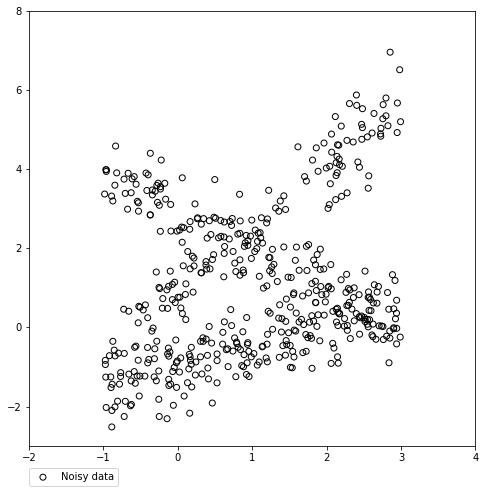

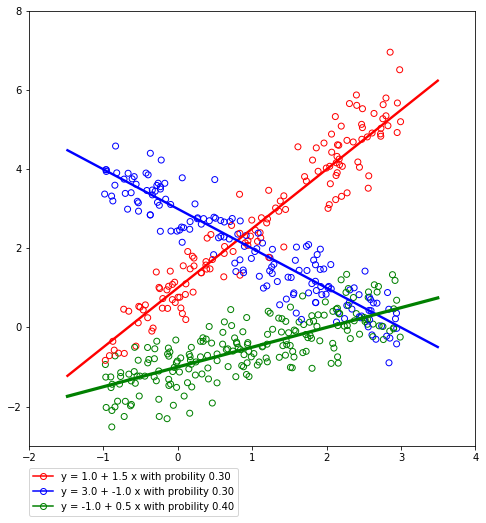

coefficients [ 2.93763084 -0.99875659] with probability [0.22199994]
coefficients [0.96348038 1.54451702] with probability [0.20500965]
coefficients [-0.93747253  0.469414  ] with probability [0.11624796]
coefficients [-1.23726517  0.68992944] with probability [0.10241401]
coefficients [ 2.93385559 -0.99771447] with probability [0.07042624]
coefficients [-0.94303223  0.47558086] with probability [0.06129055]
coefficients [-0.94458729  0.47622084] with probability [0.04448367]
coefficients [0.86296598 1.91909429] with probability [0.04344539]
coefficients [-0.94135852  0.46992979] with probability [0.03630442]
coefficients [-0.93175468  0.46128683] with probability [0.02670834]
coefficients [-0.73243318  1.81026533] with probability [0.02154017]


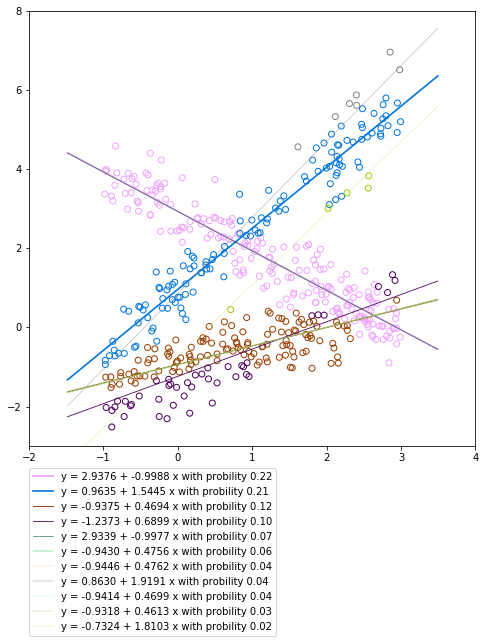

Fix x = -3.0, squared Hellinger distance for NPMLE is 0.59561
Fix x = -1.0, squared Hellinger distance for NPMLE is 0.66411
Fix x = 1.0, squared Hellinger distance for NPMLE is 0.53353
Fix x = 3.0, squared Hellinger distance for NPMLE is 0.96805
Fix x = 5.0, squared Hellinger distance for NPMLE is 1.02239


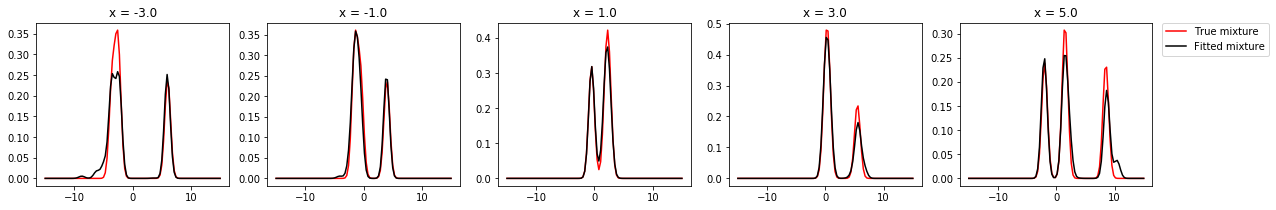

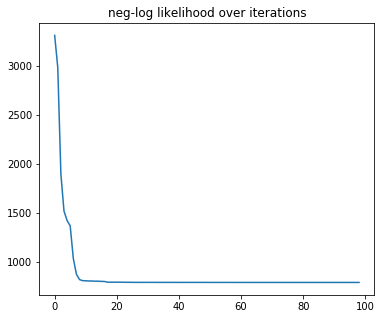

In [11]:
#colorful
test(500,100,(1,1.5),(3,-1),(-1,0.5),0.3,0.3,sigma = 0.5,sigma_est = 0.5)

# Classification EM Algorithmm

In [57]:
def CEMA(X,y,k,iter,sigma):
    '''
    Use classfication EM algorithm to fit (fixed component number) mixture of linear regression  
    sigma is estimated before
    
    Input
    X: n * p, covariate matrix
    y: n * 1, response variable
    k: number of components
    iter: number of iterations
    sigma: std of noise
    
    Output
    f: n * k, atomic likelihood vectors in active set
    B: p * k, coefficients corresponding to vectors in active set
    alpha: k*1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    L_temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    wden = np.zeros((n,k))
    w = np.zeros((n,k))
    sigma_array = np.zeros((k,))
    z = np.zeros((n,)) #latent variable, class of each data point
    f = np.zeros((n,))
    L_rec = []
    
    #intialization
    B = np.zeros((p,k))
    alpha = np.zeros(k)
    for j in range(k):
        B[:,j] = np.random.uniform(-10,10,(p,))
        alpha[j] = 1/k  
        sigma_array[j] = sigma
    
    for r in range(iter):
        
        # C step
        for i in range(n):
            for j in range(k):
                wden[i][j] = (alpha[j]*np.exp(-0.5*(y[i]- np.dot(B[:,j],X[i]))**2/(sigma_array[j]**2))/np.sqrt(2*np.pi)/sigma).ravel()
                #print('wden',wden[i][j])
        for i in range(n):
            temp = np.sum(wden[i])
            for j in range(k):
                w[i][j] = wden[i][j]/temp
            z[i] = np.argmax(np.reshape(w[i],(k,)))
            
        # record neg-log likelihood
        for i in range(n):
            f[i] = np.sum(wden[i]) 
        print(f>0)
        L_temp = np.sum(np.log(1/f))
        L_rec.append(L_temp)
        
        #M step: update B, alpha, (and sigma)
        print(alpha)
        for j in range(k):
            alpha[j] = sum(z == j)/n
            X_temp = np.zeros((sum(z == j),p))
            y_temp = np.zeros((sum(z == j),1))
            W_temp = np.zeros((sum(z == j), sum(z == j)))
            count = 0
            for i in range(n):
                if z[i] == j:
                    X_temp[count] = X[i].ravel()
                    y_temp[count] = y[i]
                    W_temp[count][count] = w[i][j]
                    count = count + 1
            temp1 = np.copy(np.linalg.pinv(np.matmul(np.matmul(X_temp.T, W_temp),X_temp))) #used generalized inverse
            temp2 = np.copy(np.matmul(np.matmul(X_temp.T, W_temp),y_temp))
            B[:,j] = (np.matmul(temp1, temp2)).ravel()
            
            sigma_temp = 0
            for i in range(n):
                sigma_temp = sigma_temp + w[i][j]*(y[i] - np.dot(B[:,j],X[i]))**2
            sigma_array[j] = np.sqrt(sigma_temp/np.sum(w[:,j]))
    return f, B, alpha, L_rec, temp


In [67]:
#test function with synthetic data
def test_EMA(n,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est, k ):
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    fname = 'EMalgorithm'
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1))
    
    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            C[i] = 2
        else:
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            C[i] = 3
            
            
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run EM
    f, B, alpha, L_rec, L_final = EMA(X,y,k,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig0 = plt.figure(figsize = (8,8))
    for i in range(len(y)):
        if C[i] == 1:
            plt.scatter(X[i][1],y[i],color = 'red',marker = 'o',label = 'Class 1', facecolors = 'None');
        elif C[i] == 2:
            plt.scatter(X[i][1],y[i],color = 'blue',marker = 'o',label = 'Class 2', facecolors = 'None');
        else:
            plt.scatter(X[i][1],y[i],color = 'green',marker = 'o',label = 'Class 3', facecolors = 'None');
            
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    i = 0
    plt.plot(t,b1[0]+b1[1]*t, color = 'red',linewidth = pi1*8 )
    plt.plot(t,b2[0]+b2[1]*t, color = 'blue',linewidth = pi2*8 )
    if pi1 + pi2 < 1:
        plt.plot(t,b3[0]+b3[1]*t, color = 'green',linewidth = (1-pi2-pi2)*8 )
           
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    if pi1 + pi2 <1:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi2),Line2D([], [], color='blue')),
                         (Line2D([], [], color='green', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*(1-pi1-pi2)),Line2D([], [], color='green'))
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                  'y = %.1f + %.1f x with probility %.2f' %(b3[0], b3[1], 1-pi1-pi2),
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc = 2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    else:
        custom_lines = [(Line2D([], [], color='red', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi1),Line2D([], [], color='red')),
                        (Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None',linewidth = 8*pi2),Line2D([], [], color='blue')),
                    
                        #Line2D([0], [0], color= 'red'# ),
                        #Line2D([0], [0], color='black')
                        #,Line2D([0], [0], color='green')#
                        ]
        plt.legend(custom_lines, ['y = %.1f + %.1f x with probility %.2f' %(b1[0], b1[1], pi1), #,'True mixture'# 
                                  'y = %.1f + %.1f x with probility %.2f' %(b2[0], b2[1], pi2),
                                
                                   #'NPMLE component'#, 'OLS'#
                                 ],loc=2,bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.show();

    
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sort = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sort:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,b[0]+b[1]*t, color = tuple( np.array(RGB_tuples[temp])/255),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with probility %.2f' %(b[0], b[1], alpha[i]))
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
            
    #plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
    
    #custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    #Line2D([0], [0], color= 'red'# ),
                    #Line2D([0], [0], color='black')
                    #,Line2D([0], [0], color='green')#
                    #,]
    #plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                            #  , 'NPMLE component'#, 'OLS'#
                            # ],loc=0);
    plt.legend(bbox_to_anchor=(0., -0.05), loc=2, borderaxespad=0.)
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,8])
    plt.show();

    
    #plot Hellinger distance
    fig2 = plt.figure(figsize = (20,3))
    x_list = [-3,-1,1,3,5] #List of x values
    i = 0
    
    for i in range(len(x_list)):
        x = x_list[i]
        y = np.linspace(- 15, 15, 100)
           
        #calculate difference of suqre root of density functions
        dist_fit = lambda y: (np.sqrt(0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x), 0, sigma)+0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x),0, sigma)) \
        - np.sqrt(sum(alpha[i]*scipy.stats.norm.pdf( y - (B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha)))))**2
        
        print("Fix x = %.1f, squared Hellinger distance for NPMLE is %.5f" % (x, quad(dist_fit, -np.inf, np.inf)[0]))

        
        plt.subplot(1,len(x_list),i+1)
        plt.plot(y,pi1*scipy.stats.norm.pdf(y - (b1[0]+b1[1]*x), 0, sigma)+pi2*scipy.stats.norm.pdf(y-(b2[0]+b2[1]*x),0, sigma)+(1-pi1-pi2)*scipy.stats.norm.pdf(y-(b3[0]+b3[1]*x),0, sigma),'red',label = 'True distribution')
        plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-(B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha))),'black',label = 'NPMLE distribution')
        plt.title("x = %.1f"%x)
    custom_lines = [
                Line2D([0], [0], color= 'red'),
                Line2D([0], [0], color='black'),
                #Line2D([0], [0], color='green')#
        ]
    plt.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lgd = ax.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig('./pics/%s_density.png'%fname, dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    
    fig3 = plt.figure(figsize = (6,5))
    plt.plot(L_rec);plt.title("neg-log likelihood over iterations");
      
    

In [70]:
def EMA(X,y,k,iter,sigma):
    '''
    Use EM algorithm to fit (fixed component number) mixture of linear regression  
    sigma is estimated before
    
    Input
    X: n * p, covariate matrix
    y: n * 1, response variable
    k: number of components
    iter: number of iterations
    sigma: std of noise
    
    Output
    f: n * k, atomic likelihood vectors in active set
    B: p * k, coefficients corresponding to vectors in active set
    alpha: k*1, mixing proportions of vectors in active set
    L_rec: neg-log likelihood over iterations
    L_temp: final neg-log likelihood
    
    '''  
    n = len(X)
    p = len(X[0])
    wden = np.zeros((n,k))
    w = np.zeros((n,k))
    sigma_array = np.zeros((k,))
    z = np.zeros((n,)) #latent variable, class of each data point
    f = np.zeros((n,))
    L_rec = []
    
    #intialization
    B = np.zeros((p,k))
    alpha = np.zeros((k,1))
    for j in range(k):
        B[:,j] = np.random.uniform(-10,10,(p,))
        alpha[j][0] = 1/k  
        sigma_array[j] = sigma
    
    for r in range(iter):
        
        # C step
        for i in range(n):
            wden_temp = 0
            for j in range(k):
                wden_temp = max(wden_temp, (y[i]- np.dot(B[:,j],X[i]))**2 )
            for j in range(k):
                if ((y[i]- np.dot(B[:,j],X[i]))**2-wden_temp) < -20:
                    wden[i][j] = 0
                else:
                    wden[i][j] = (alpha[j]*np.exp(-0.5*((y[i]- np.dot(B[:,j],X[i]))**2 - wden_temp)/(sigma_array[j]**2))/np.sqrt(2*np.pi)/sigma).ravel()
                    
        for i in range(n):
            temp = np.sum(wden[i])
            for j in range(k):
                w[i][j] = wden[i][j]/temp
            
        # record neg-log likelihood
        for i in range(n):
            f[i] = np.sum(wden[i]) 
        L_temp = np.sum(np.log(1/f))
        L_rec.append(L_temp)
        
        #M step: update B, alpha, (and sigma)
        for j in range(k):
            alpha[j] = np.sum(w[:,j])/n
            w_diag = np.diag(w[:,j])
            
            #update B
            temp1 = np.linalg.pinv(np.matmul(np.matmul(X.T, w_diag),X))
            temp2 = np.matmul(np.matmul(X.T,w_diag),y)
            B[:,j] = np.dot(temp1, temp2).ravel()
            
            #update sigma
            #sigma_temp = 0
            #for i in range(n):
            #    sigma_temp = sigma_temp + w[i][j]*(y[i] - np.dot(B[:,j],X[i]))**2
            #sigma_array[j] = np.sqrt(sigma_temp/np.sum(w[:,j]))
    return f, B, alpha, L_rec, temp

averge beta is  [[2.50610139]
 [0.02620275]]
training error is  2.2040643416924355
beta_ols [[ 2.6041007 ]
 [-0.01348184]]
final neg log likelihood is  0.5342782211229595
number of components is 2
only components with probability at least  0.02  are shown below:


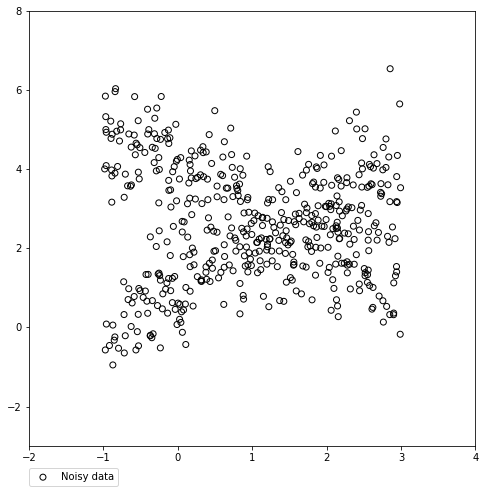

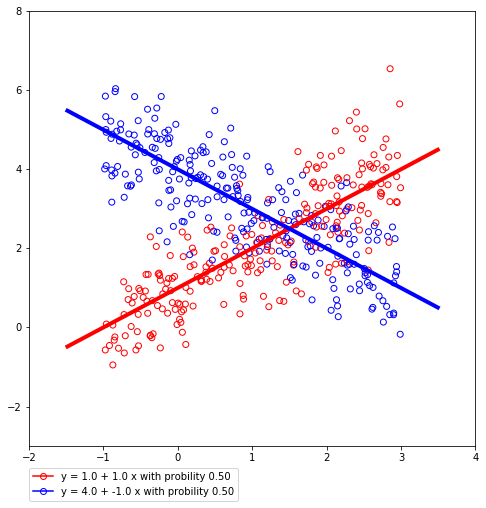

coefficients [ 3.87046275 -0.94359211] with probability [0.50037236]
coefficients [1.13970636 0.99744316] with probability [0.49962764]


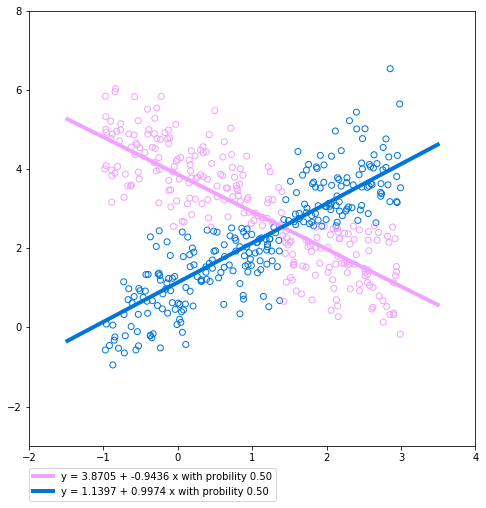

Fix x = -3.0, squared Hellinger distance for NPMLE is 0.59230
Fix x = -1.0, squared Hellinger distance for NPMLE is 0.58527
Fix x = 1.0, squared Hellinger distance for NPMLE is 0.10190
Fix x = 3.0, squared Hellinger distance for NPMLE is 0.46926
Fix x = 5.0, squared Hellinger distance for NPMLE is 0.59068


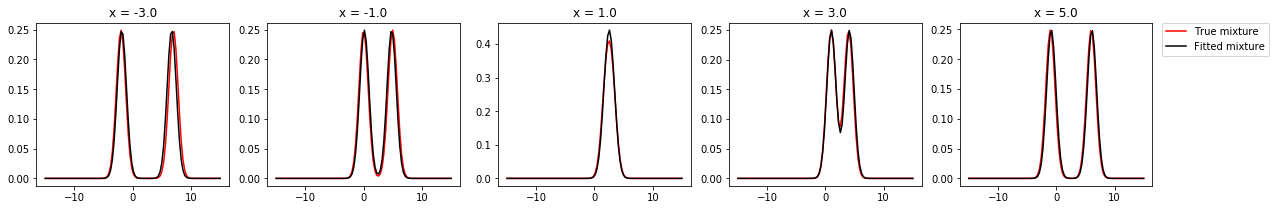

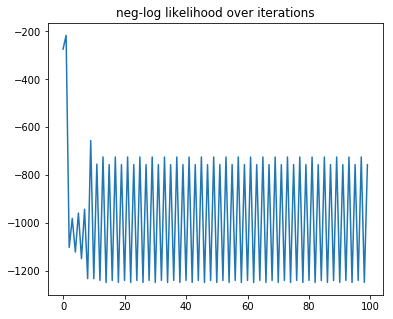

In [71]:
#colorful
test_EMA(500,100,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8,k = 2)

beta_sol [ 2.3655053  -0.23942041]
beta_sol [ 1.41029601 -1.20394109]
beta_sol [-0.92296487 -0.24341652]
beta_sol [0.74349371 0.12021021]
beta_sol [ 0.86616635 -0.92605508]
beta_sol [-0.23805165 -0.14123012]
beta_sol [-0.06390158  0.59156072]
beta_sol [ 1.28362004 -0.29717044]
beta_sol [ 1.12895217 -0.98473955]
beta_sol [ 1.27993161 -0.28918071]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 -0.2892079 ]
beta_sol [ 1.27993159 -0.28918067]
beta_sol [ 1.27997477 

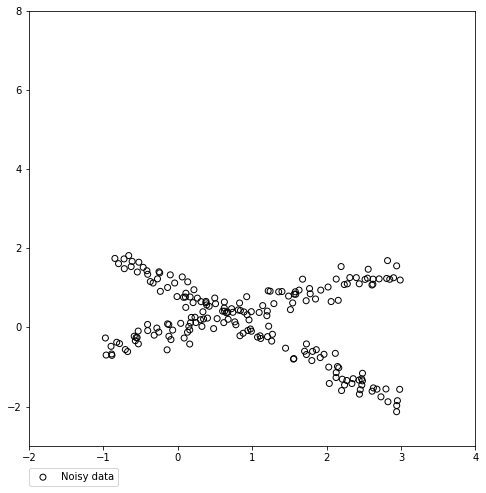

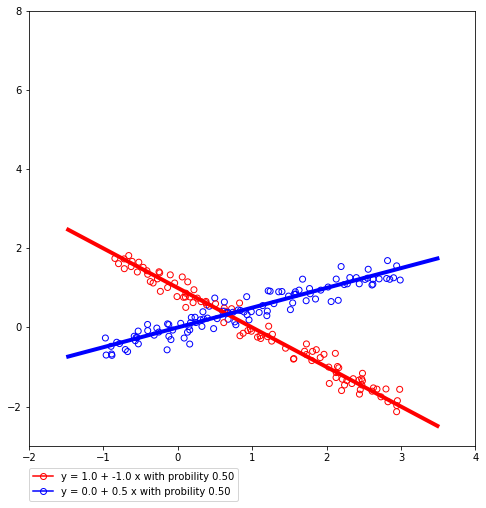

coefficients [-0.06390158  0.59156072] with probability [0.46053121]
coefficients [ 0.86616635 -0.92605508] with probability [0.38715924]
coefficients [ 1.12895217 -0.98473955] with probability [0.11797002]
coefficients [0.74349371 0.12021021] with probability [0.03433953]


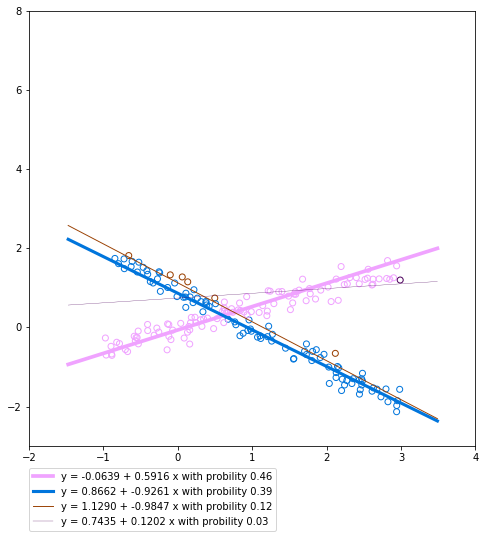

Fix x = -3.0, squared Hellinger distance for NPMLE is 0.81331
Fix x = -1.0, squared Hellinger distance for NPMLE is 0.65817
Fix x = 1.0, squared Hellinger distance for NPMLE is 0.33813
Fix x = 3.0, squared Hellinger distance for NPMLE is 0.62894
Fix x = 5.0, squared Hellinger distance for NPMLE is 0.79254


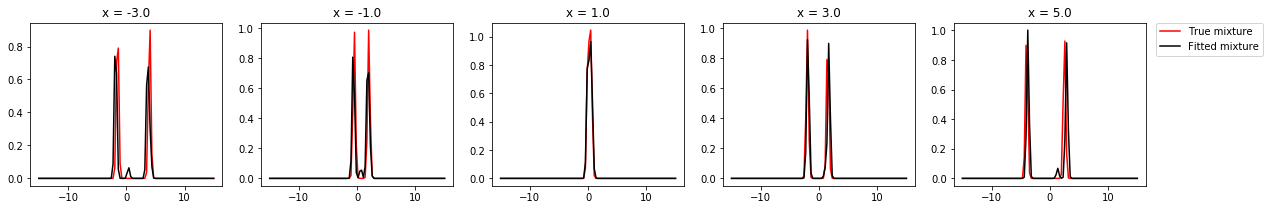

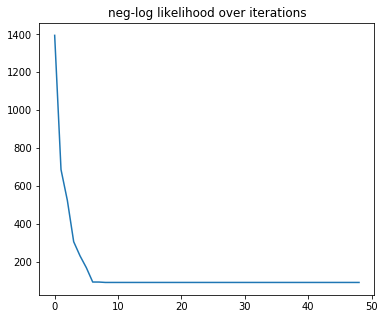

In [62]:
test(200,50,(1,-1),(0,0.5),(-1,0.5),0.5,0.5,sigma = 0.2,sigma_est=0.2)

__Empirical Bayes__

averge beta is  [[ 2.5467214 ]
 [-0.01955288]]
training error is  1.592245551788678
beta_ols [[ 2.65580034]
 [-0.04711867]]
final neg log likelihood is  267.2114936662171
number of components is 22
only components with probability at least  0.02  are shown below:


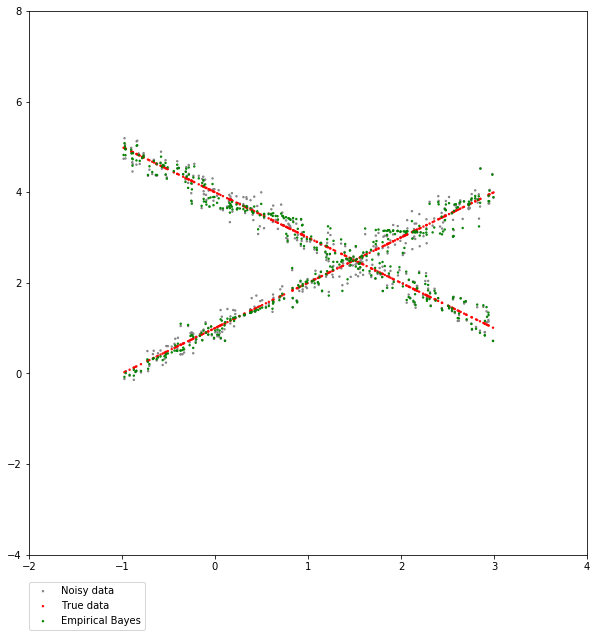

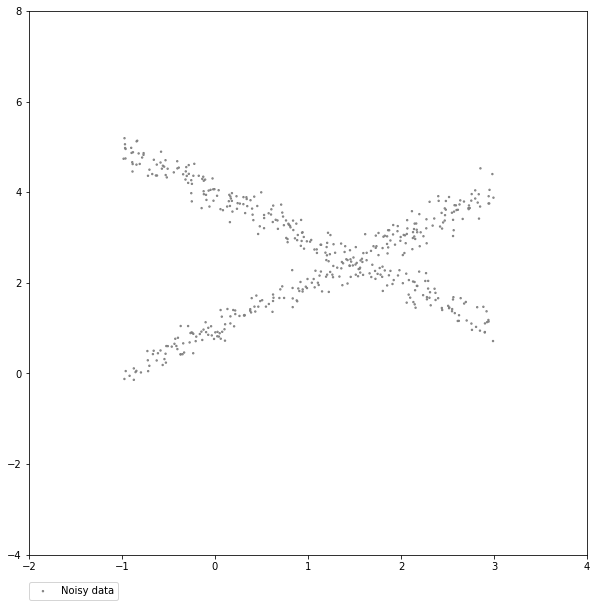

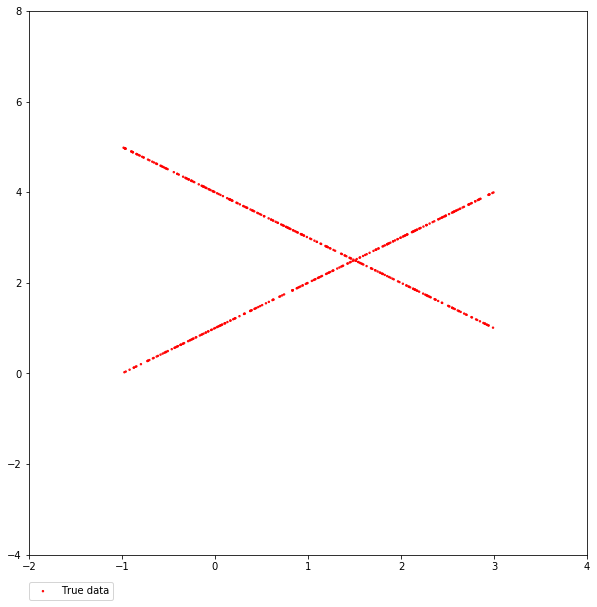

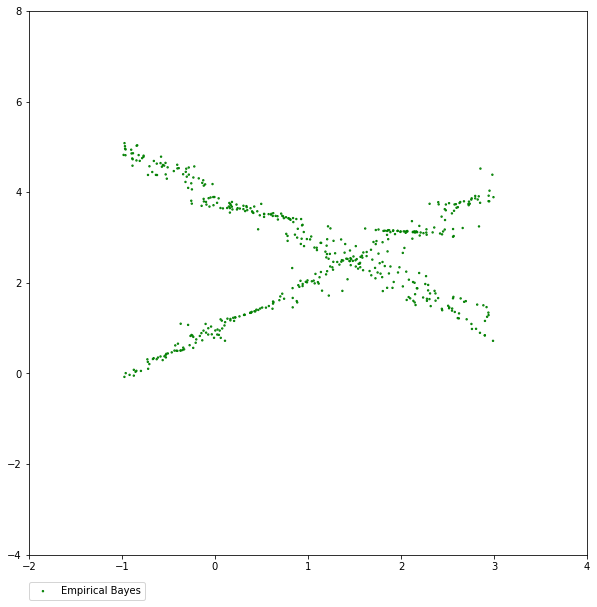

In [12]:
#Powell
test_EB(500,50,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.2,sigma_est=0.2)

beta_sol [-1.21378655 -6.58674544]
beta_sol [-4.73341274 -5.25410976]
beta_sol [-0.00826875 -0.8749676 ]
beta_sol [14.28774253 16.20897169]
beta_sol [-0.65275054  1.81442044]
beta_sol [ 2.91536801 -7.68136811]
beta_sol [5.41463276 2.2057106 ]
beta_sol [-7.59800225 -7.69083412]
beta_sol [-4.20475945  1.64525699]
beta_sol [3.87596352 4.20231176]
beta_sol [ 1.37450117 -0.02674325]
beta_sol [ 6.34735281 -4.72432207]
beta_sol [-3.81854528 -5.41498252]
beta_sol [ 1.90602989 -3.8410059 ]
beta_sol [-7.25596094  3.73759647]
beta_sol [ 3.79016506 -0.11615017]
beta_sol [ 4.50136576 -0.20041669]
beta_sol [0.73007372 0.61629641]
beta_sol [ 3.26534314 -0.11163407]
beta_sol [1.04149302 0.95638733]
beta_sol [ 4.07227938 -1.08305657]
beta_sol [2.43718828 5.59275738]
beta_sol [ 4.28260715 -0.20348123]
beta_sol [ 3.76480255 -0.78231889]
beta_sol [3.04196909 0.31082049]
beta_sol [ 1.07248959 -4.05386955]
beta_sol [3.76099774 0.01362721]
beta_sol [ 3.92614965 -0.91684032]
beta_sol [1.44437388 1.00765701]
b

beta_sol [0.61975055 6.79554201]
beta_sol [ 3.98560597 -0.99875641]
beta_sol [ 4.09904505 -0.5709352 ]
beta_sol [-6.50804378  3.82494758]
beta_sol [ 3.98630608 -0.99913506]
beta_sol [-4.90715783  3.13096765]
beta_sol [2.13811091 7.42144354]
beta_sol [ 4.00477706 -0.9523858 ]
beta_sol [0.98273038 1.00248211]
beta_sol [-4.90722631  3.13111624]
beta_sol [-1.30881664 -6.5661553 ]
beta_sol [ 3.97886176 -0.99287071]
beta_sol [ 4.004164   -0.95206512]
beta_sol [ 4.09891898 -0.57085896]
beta_sol [ 6.43743965 -4.88648709]
beta_sol [-2.34959056 -7.70691863]
beta_sol [-12.31059836   6.41220201]
beta_sol [0.98233595 1.00477313]
beta_sol [4.78686806 8.20893847]
beta_sol [ 12.45406819 -12.25921221]
beta_sol [1.00397232 1.13363487]
beta_sol [0.61976096 6.79552255]
beta_sol [0.99960381 1.08387017]
beta_sol [ 4.00533871 -0.95367543]
beta_sol [5.31088252 6.19574535]
beta_sol [ 3.99106688 -0.95475877]
beta_sol [ 3.99099309 -0.97587442]
beta_sol [0.98228699 1.00475752]
beta_sol [4.78684892 8.20891257]
bet

beta_sol [-6.64944121  7.84484701]
beta_sol [-5.23726531  9.07528623]
beta_sol [4.37140668 5.17884581]
beta_sol [-1.30674212 -6.55478367]
beta_sol [0.58424516 6.87255158]
beta_sol [0.96723252 0.95403073]
beta_sol [2.29711345 3.4750285 ]
beta_sol [ 4.21615633 -0.50848309]
beta_sol [0.95947536 0.9093733 ]
beta_sol [0.98174661 1.00291907]
beta_sol [0.98228655 1.00274338]
beta_sol [ 3.98071278 -0.99575891]
beta_sol [-1.04270315 -7.41814261]
beta_sol [ 4.00331538 -0.95299385]
beta_sol [-1.30762825 -6.54326682]
beta_sol [0.95967347 0.90712481]
beta_sol [-6.50822748  3.83077473]
beta_sol [-4.79543521  3.08532716]
beta_sol [ 3.86952351 -0.95246123]
beta_sol [19.64565734 -7.66524913]
beta_sol [1.92512118 2.49832484]
averge beta is  [[ 2.50789035]
 [-0.00581441]]
training error is  1.5981560963990697
beta_ols [[ 2.65580034]
 [-0.04711867]]
final neg log likelihood is  220.47931917535647
number of components is 188
only components with probability at least  0.02  are shown below:


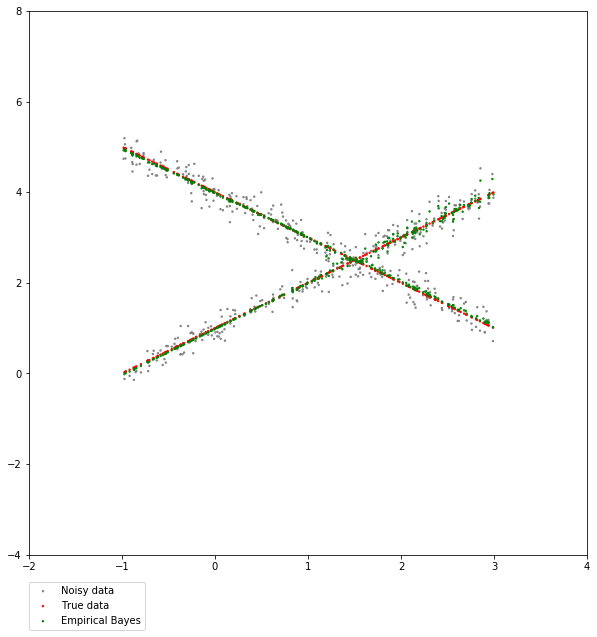

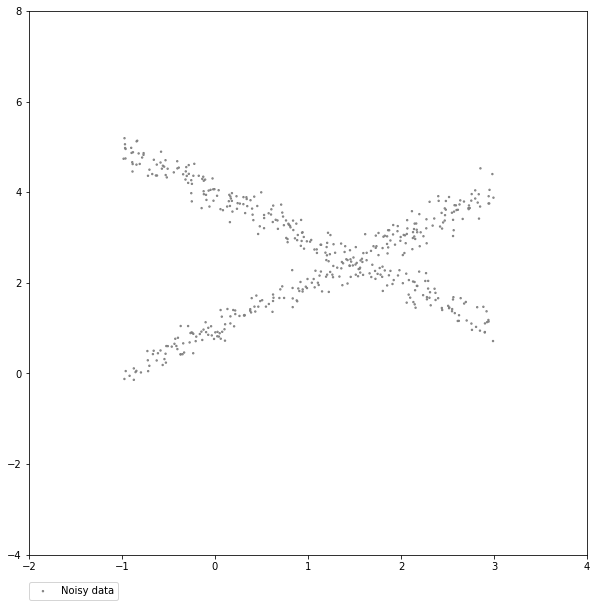

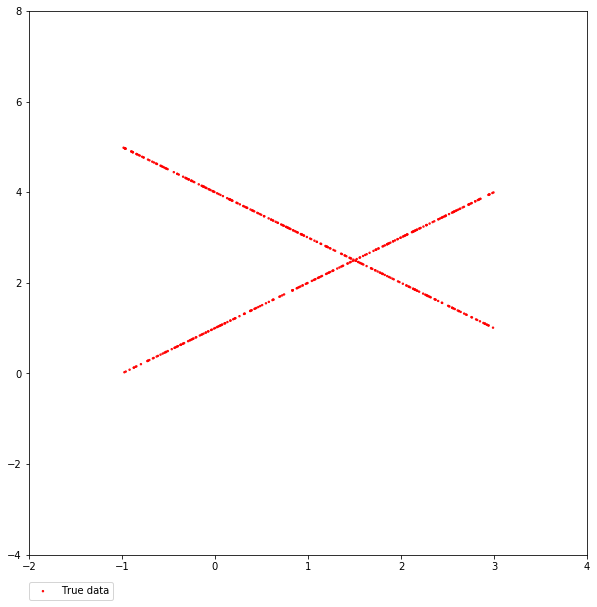

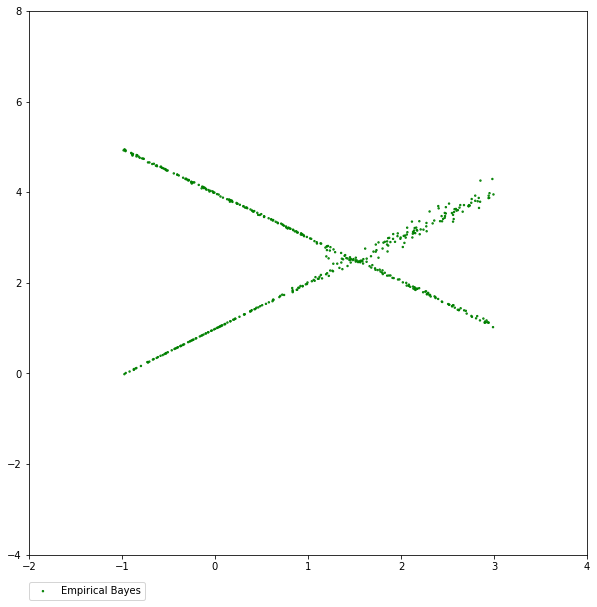

In [49]:
#BFGS with random initialization
test_EB(500,500,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.2,sigma_est=0.2)

beta_sol [-1.21378655 -6.58674544]
beta_sol [-4.73341274 -5.25410976]
beta_sol [-0.00826875 -0.8749676 ]
beta_sol [14.28774253 16.20897169]
beta_sol [-0.65275054  1.81442044]
beta_sol [ 2.91536801 -7.68136811]
beta_sol [5.41463276 2.2057106 ]
beta_sol [-7.59800225 -7.69083412]
beta_sol [-4.20475945  1.64525699]
beta_sol [3.87596352 4.20231176]
beta_sol [ 1.37450117 -0.02674325]
beta_sol [ 6.34735281 -4.72432207]
beta_sol [-3.81854528 -5.41498252]
beta_sol [ 1.90602989 -3.8410059 ]
beta_sol [-7.25596094  3.73759647]
beta_sol [ 3.79016506 -0.11615017]
beta_sol [ 4.50136576 -0.20041669]
beta_sol [0.73007372 0.61629641]
beta_sol [ 3.26534314 -0.11163407]
beta_sol [1.04149302 0.95638733]
beta_sol [ 4.07227938 -1.08305657]
beta_sol [2.43718828 5.59275738]
beta_sol [ 4.28260715 -0.20348123]
beta_sol [ 3.76480255 -0.78231889]
beta_sol [3.04196909 0.31082049]
beta_sol [ 1.07248959 -4.05386955]
beta_sol [3.76099774 0.01362721]
beta_sol [ 3.92614965 -0.91684032]
beta_sol [1.44437388 1.00765701]
b

beta_sol [0.61975055 6.79554201]
beta_sol [ 3.98560597 -0.99875641]
beta_sol [ 4.09904505 -0.5709352 ]
beta_sol [-6.50804378  3.82494758]
beta_sol [ 3.98630608 -0.99913506]
beta_sol [-4.90715783  3.13096765]
beta_sol [2.13811091 7.42144354]
beta_sol [ 4.00477706 -0.9523858 ]
beta_sol [0.98273038 1.00248211]
beta_sol [-4.90722631  3.13111624]
beta_sol [-1.30881664 -6.5661553 ]
beta_sol [ 3.97886176 -0.99287071]
beta_sol [ 4.004164   -0.95206512]
beta_sol [ 4.09891898 -0.57085896]
beta_sol [ 6.43743965 -4.88648709]
beta_sol [-2.34959056 -7.70691863]
beta_sol [-12.31059836   6.41220201]
beta_sol [0.98233595 1.00477313]
beta_sol [4.78686806 8.20893847]
beta_sol [ 12.45406819 -12.25921221]
beta_sol [1.00397232 1.13363487]
beta_sol [0.61976096 6.79552255]
beta_sol [0.99960381 1.08387017]
beta_sol [ 4.00533871 -0.95367543]
beta_sol [5.31088252 6.19574535]
beta_sol [ 3.99106688 -0.95475877]
beta_sol [ 3.99099309 -0.97587442]
beta_sol [0.98228699 1.00475752]
beta_sol [4.78684892 8.20891257]
bet

beta_sol [-6.64944121  7.84484701]
beta_sol [-5.23726531  9.07528623]
beta_sol [4.37140668 5.17884581]
beta_sol [-1.30674212 -6.55478367]
beta_sol [0.58424516 6.87255158]
beta_sol [0.96723252 0.95403073]
beta_sol [2.29711345 3.4750285 ]
beta_sol [ 4.21615633 -0.50848309]
beta_sol [0.95947536 0.9093733 ]
beta_sol [0.98174661 1.00291907]
beta_sol [0.98228655 1.00274338]
beta_sol [ 3.98071278 -0.99575891]
beta_sol [-1.04270315 -7.41814261]
beta_sol [ 4.00331538 -0.95299385]
beta_sol [-1.30762825 -6.54326682]
beta_sol [0.95967347 0.90712481]
beta_sol [-6.50822748  3.83077473]
beta_sol [-4.79543521  3.08532716]
beta_sol [ 3.86952351 -0.95246123]
beta_sol [19.64565734 -7.66524913]
beta_sol [1.92512118 2.49832484]
averge beta is  [[ 2.50789035]
 [-0.00581441]]
training error is  1.5981560963990697
beta_ols [[ 2.65580034]
 [-0.04711867]]
final neg log likelihood is  220.47931917535647
number of components is 188
only components with probability at least  0.02  are shown below:


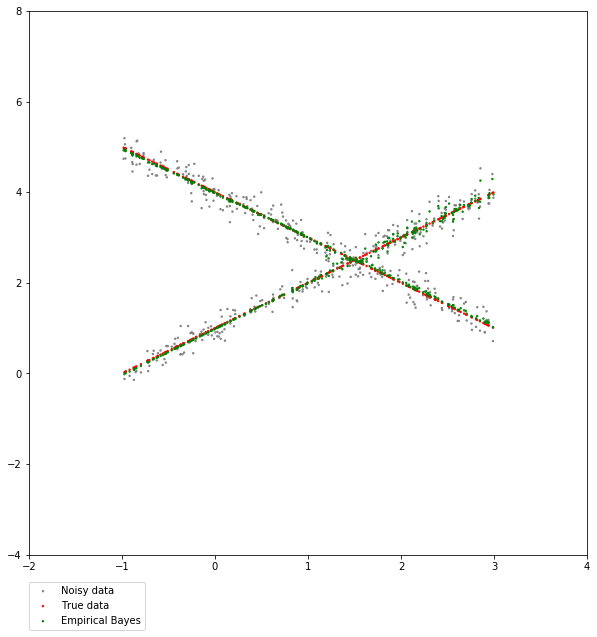

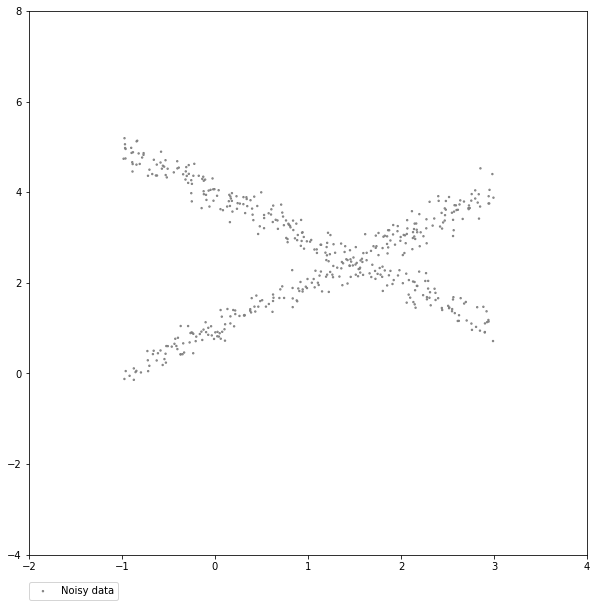

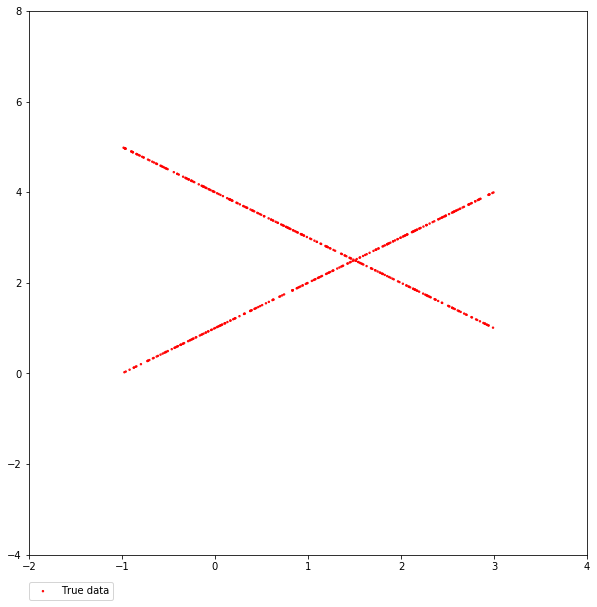

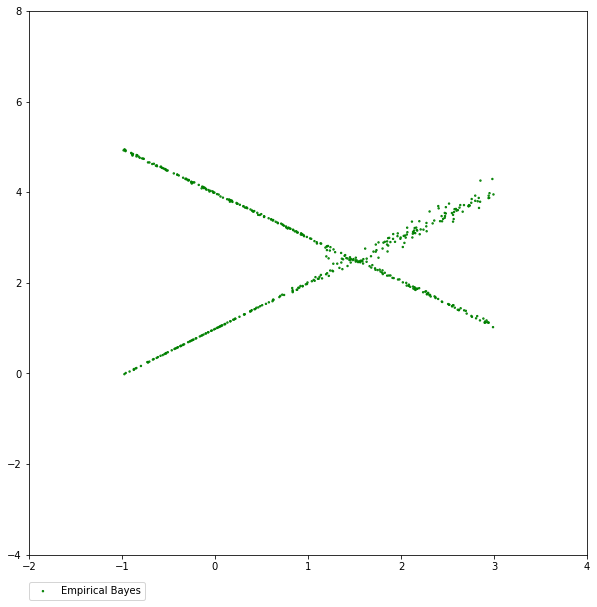

In [40]:
#BFGS
test_EB(500,500,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.2,sigma_est=0.2)

beta_sol [5.52307987 0.01783688]
beta_sol [-5.11455111 -5.22841548]
beta_sol [0.0677516  0.11030915]
beta_sol [ 4.23273599 -0.06445279]
beta_sol [1.13214792 0.1668814 ]
beta_sol [5.24995696 0.04868808]
beta_sol [0.77525366 1.12795866]
beta_sol [ 4.23556072 -1.26749967]
beta_sol [1.24944131 1.44655442]
beta_sol [ 0.54922587 -4.34579448]
beta_sol [ 3.67191273 -0.64670233]
beta_sol [ 4.02066071 -0.9753875 ]
beta_sol [ 3.28101071 -0.90806282]
beta_sol [ 0.36502792 -4.23569159]
beta_sol [1.36448411 0.71545514]
beta_sol [ 3.59402583 -0.96334511]
beta_sol [1.16092836 1.28287003]
beta_sol [ 4.07964727 -0.43159013]
beta_sol [ 4.06498094 -0.72373253]
beta_sol [1.063442   0.93243855]
beta_sol [0.94819325 1.07749541]
beta_sol [0.9788178  1.45011389]
beta_sol [ 4.09956882 -0.75339433]
beta_sol [ 4.09061718 -0.7503917 ]
beta_sol [ 4.09326516 -0.74987736]
beta_sol [ 3.93770738 -1.06568158]
beta_sol [ 3.9891388  -0.78458455]
beta_sol [ 4.05778775 -0.79523614]
beta_sol [0.89129135 0.94728989]
beta_sol 

beta_sol [2.85680379 3.52308497]
beta_sol [1.03548308 1.3356934 ]
beta_sol [2.85682698 3.52304567]
beta_sol [0.98724845 1.0049649 ]
beta_sol [ 3.57509299 -0.91053926]
beta_sol [ 3.95474857 -1.01168283]
beta_sol [ 4.07205029 -0.8164174 ]
beta_sol [ 4.07131457 -0.81700946]
beta_sol [1.03534503 1.33574734]
beta_sol [0.95620738 0.99168822]
beta_sol [ 3.57050507 -0.90871273]
beta_sol [ 3.53477424 -0.9008938 ]
beta_sol [ 4.07089889 -0.81519885]
beta_sol [ 4.08272069 -0.39988692]
beta_sol [ 3.57220057 -0.90958645]
beta_sol [ 3.555685   -0.90228125]
beta_sol [0.96833143 1.00685132]
beta_sol [0.96833127 1.00685034]
beta_sol [ 4.07061184 -0.81523177]
beta_sol [0.96832308 1.00683808]
beta_sol [0.96832362 1.00683625]
beta_sol [2.85663956 3.52316973]
beta_sol [1.03541403 1.3356171 ]
beta_sol [ 4.06780041 -0.81756674]
beta_sol [0.96894215 1.00855006]
beta_sol [ 4.07100036 -0.81460186]
beta_sol [2.48147739 0.46844555]
beta_sol [0.96831874 1.0068114 ]
beta_sol [ 4.07116096 -0.81467155]
beta_sol [ 4.07

beta_sol [0.97556059 1.02737973]
beta_sol [2.85656463 3.52325204]
beta_sol [ 1.1933531  -9.73121176]
beta_sol [0.96848027 1.007251  ]
beta_sol [1.03542018 1.33643837]
beta_sol [2.85683065 3.52321915]
beta_sol [ 4.07170652 -0.81530021]
beta_sol [2.47424085 0.47080676]
beta_sol [ 3.58248647 -0.91212244]
beta_sol [1.0353534 1.3360382]
beta_sol [ 4.07126914 -0.81476957]
beta_sol [ 3.58208202 -0.91183083]
beta_sol [ 4.07236997 -0.81538491]
beta_sol [0.97137605 1.00955899]
beta_sol [2.85666524 3.52315986]
beta_sol [0.96843411 1.00714321]
beta_sol [ 3.95051497 -1.01178189]
beta_sol [ 4.06794766 -0.81729266]
beta_sol [ 3.58162883 -0.91330945]
beta_sol [ 3.48848568 -0.88558276]
averge beta is  [[2.5020695 ]
 [0.01903491]]
training error is  1.8105768374625228
beta_ols [[ 2.62995052]
 [-0.03030025]]
final neg log likelihood is  617.034021211264
number of components is 274
only components with probability at least  0.02  are shown below:


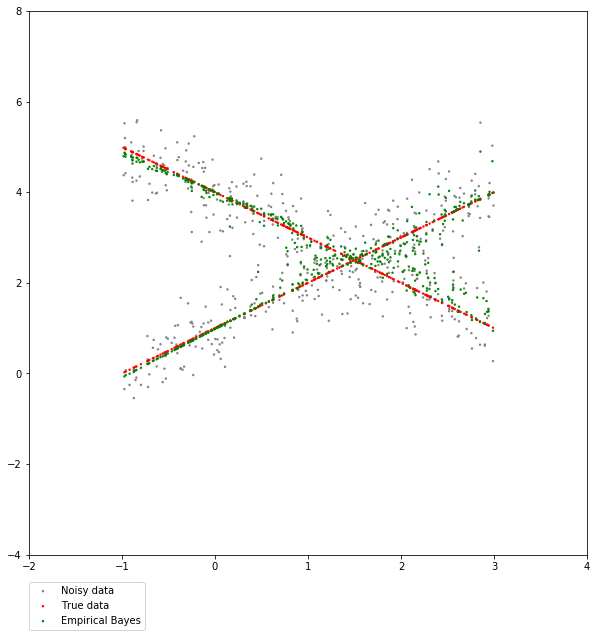

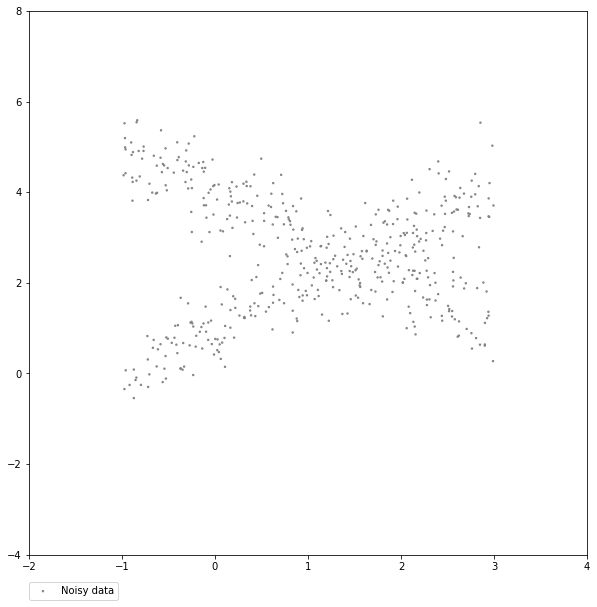

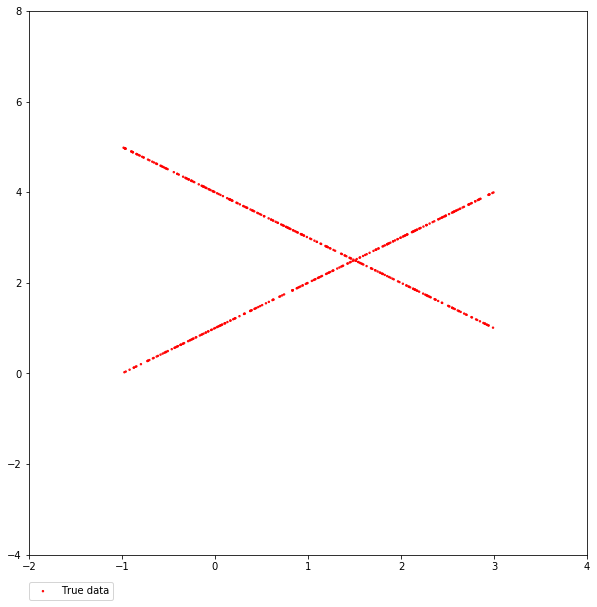

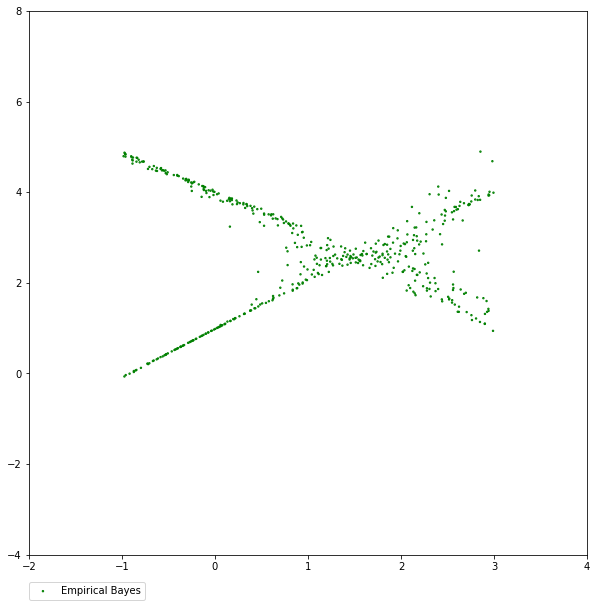

In [52]:
test_EB(500,500,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.5,sigma_est=0.5)

beta_sol [7.48210455 9.47774209]
beta_sol [1.54227135 1.66332478]
beta_sol [5.63344298 1.61177756]
beta_sol [-1.73627067  0.37541588]
beta_sol [3.5484738  1.19714165]
beta_sol [10.66849528 -2.58317418]
beta_sol [-2.18880977 -6.39159057]
beta_sol [2.27256783 7.70986178]
beta_sol [0.31146351 1.5569685 ]
beta_sol [-0.56550203  0.39720163]
beta_sol [ 3.02629995 -1.00575628]
beta_sol [1.01580327 1.54830805]
beta_sol [-4.01171332  3.59431948]
beta_sol [ 2.6712063  -1.02786855]
beta_sol [ 1.64868815 -2.54264281]
beta_sol [-1.2398935   0.48525802]
beta_sol [1.04023708 1.30032285]
beta_sol [-0.95655193  0.52997004]
beta_sol [ 2.83078806 -0.99820672]
beta_sol [-0.87590871  0.37977158]
beta_sol [ 2.92006575 -0.98333783]
beta_sol [ 1.65388156 -0.42575097]
beta_sol [-1.22111262  0.56988411]
beta_sol [-1.02282992  0.48497914]
beta_sol [-5.91925647  9.58546183]
beta_sol [ 2.95219399 -1.03253885]
beta_sol [ 1.60164501 -0.37423834]
beta_sol [-0.73158602  1.21526774]
beta_sol [ 2.51067323 -3.60325575]
b

beta_sol [2.17413802 1.00724182]
beta_sol [ 2.94819056 -0.99671649]
beta_sol [-0.00911898 -0.10902412]
beta_sol [ 2.94817939 -0.99672046]
beta_sol [ 2.94817783 -0.99669952]
beta_sol [-3.15607056 -9.06290802]
beta_sol [ 8.53901299 -4.20819636]
beta_sol [-5.44980662  5.92133375]
beta_sol [ 2.94809481 -0.99687102]
beta_sol [-7.11510599  4.67168241]
beta_sol [ 7.98386602 11.1340263 ]
beta_sol [5.53887174 7.7521005 ]
beta_sol [-5.98216038  9.69299206]
beta_sol [1.01725196 1.47868596]
beta_sol [ 2.94815165 -0.99676014]
beta_sol [ 2.94817689 -0.99672694]
beta_sol [ 8.53914015 -4.20828192]
beta_sol [-2.88218579 -7.30143332]
beta_sol [1.03501537 1.70695294]
beta_sol [ 2.94815902 -0.99676244]
beta_sol [5.5389764  7.75231899]
beta_sol [ 2.94819367 -0.99674337]
beta_sol [-3.95212135  3.56840401]
beta_sol [-3.15173406 -9.055382  ]
beta_sol [ 2.94813511 -0.99676728]
beta_sol [ 2.94812952 -0.99672385]
beta_sol [ 2.94820753 -0.99664016]
beta_sol [-1.086566    0.54385692]
beta_sol [0.90673647 4.5757603

beta_sol [-0.96618074  0.49261064]
beta_sol [1.0392274  1.52124733]
beta_sol [1.01602993 1.47515015]
beta_sol [-0.96373113  0.4948693 ]
beta_sol [  0.04384881 -10.69651192]
beta_sol [-0.16829153  6.7707937 ]
beta_sol [-0.96789199  0.49216503]
beta_sol [ 2.94815117 -0.99673792]
beta_sol [ 2.94767507 -0.99650969]
beta_sol [5.5388612  7.75202197]
beta_sol [-1.3332227   2.08272048]
beta_sol [-3.94882265  3.54419165]
beta_sol [-0.95727818  0.48892489]
beta_sol [3.16745578 0.41366062]
beta_sol [ 2.94813213 -0.99674055]
beta_sol [1.01685909 1.47766926]
beta_sol [-3.96519128  3.56531189]
beta_sol [1.01680672 1.47767979]
beta_sol [ 2.94813768 -0.99674102]
beta_sol [5.53893615 7.75215956]
beta_sol [-0.97164886  0.49459018]
beta_sol [ 7.98419902 11.13489337]
beta_sol [ 6.23464823 -2.64816439]
beta_sol [-1.14233134  0.56014803]
beta_sol [ 2.94801706 -0.99680953]
beta_sol [-5.98217982  9.69308697]
beta_sol [-3.96542134  3.56539619]
beta_sol [-0.82164231  0.60605359]
beta_sol [-7.11861531  4.6806653

beta_sol [-0.14603865  6.74060958]
beta_sol [-1.42393987  2.37672377]
beta_sol [-1.15442313  0.56588157]
beta_sol [ 2.9479995  -0.99657356]
beta_sol [ 2.9481161  -0.99672557]
beta_sol [1.04159744 1.66290647]
beta_sol [1.01553222 1.47398659]
beta_sol [-0.81199117  0.60887115]
beta_sol [-12.70559215  10.53250061]
beta_sol [1.01674335 1.477692  ]
beta_sol [ 2.94812421 -0.9967168 ]
beta_sol [-3.9664871   3.56614154]
beta_sol [-1.16477262  0.56949397]
beta_sol [1.0167359  1.47769615]
beta_sol [ 2.94884955 -0.99580051]
beta_sol [-0.81167953  0.60948139]
beta_sol [ 6.17212626 -2.59823884]
beta_sol [-3.15179594 -9.05558232]
beta_sol [ 2.9477667  -0.99386275]
beta_sol [ 1.57219899 -0.34258346]
beta_sol [ 2.94811939 -0.99671897]
beta_sol [-0.96300226  0.49157993]
beta_sol [ 6.82216153 -7.25259375]
beta_sol [ 2.9481563  -0.99674195]
beta_sol [-0.81323281  0.60868904]
beta_sol [-0.7895488   0.81501833]
beta_sol [5.51386788 7.73557001]
beta_sol [-0.96291662  0.49174424]
beta_sol [1.02327754 1.50277

beta_sol [-0.79690501 -5.48950135]
beta_sol [ 2.94815416 -0.99669838]
beta_sol [ 2.94812313 -0.99675806]
beta_sol [-0.96440847  0.49187158]
beta_sol [1.01704416 1.47847602]
beta_sol [ 6.82200933 -7.25235221]
beta_sol [ 1.4909798  -6.59515291]
beta_sol [0.88412466 4.64130233]
beta_sol [-12.69356696  10.52376888]
beta_sol [-1.42390924  2.37687967]
beta_sol [-1.16774387  0.56679009]
beta_sol [0.88471808 4.63883659]
beta_sol [1.01702545 1.47850249]
beta_sol [-0.14919643  6.7641735 ]
beta_sol [-0.95917261  0.48975674]
beta_sol [0.88391427 4.63972488]
beta_sol [-1.16802704  0.57066929]
beta_sol [ 2.9481298  -0.99674039]
beta_sol [-1.4257906   2.37865722]
beta_sol [-1.42391991  2.37688178]
beta_sol [1.01665593 1.47832101]
beta_sol [-1.42391338  2.37687496]
beta_sol [-1.42376005  2.37691531]
beta_sol [0.88388149 4.63972523]
beta_sol [5.53896414 7.75227801]
beta_sol [-0.79689711 -5.48942502]
beta_sol [1.01705017 1.47842776]
beta_sol [-1.42393043  2.37687831]
beta_sol [ 2.9481422  -0.99675241]
b

beta_sol [ 2.94811577 -0.99676803]
beta_sol [-0.81395644  0.60900492]
beta_sol [-1.16591403  0.56804251]
beta_sol [1.01673035 1.47751493]
beta_sol [-0.14935506  6.76428201]
beta_sol [-0.28573943  1.9786009 ]
beta_sol [-9.50893636 -8.47918895]
beta_sol [-0.88498869  0.57306759]
beta_sol [ 2.94809655 -0.99677488]
beta_sol [1.01665525 1.47730243]
beta_sol [-0.79689533 -5.48944614]
beta_sol [ 0.64466992 -3.63053346]
beta_sol [ 2.94825475 -0.99678976]
beta_sol [1.00641686 1.44694222]
beta_sol [ 2.94811562 -0.99676337]
beta_sol [-0.15008525  6.76572422]
beta_sol [-0.81533006  0.60866812]
beta_sol [1.02847725 1.4665891 ]
beta_sol [-7.11383277  4.67090728]
beta_sol [-3.151801   -9.05556916]
beta_sol [ 2.94807392 -0.99680641]
beta_sol [ 6.26304763 -2.64308322]
beta_sol [ 2.94782204 -0.99657342]
beta_sol [-0.96095066  0.48850891]
beta_sol [ 2.94788719 -0.99717436]
beta_sol [ 1.49096854 -6.59529127]
beta_sol [ 6.71040604 -7.04168045]
beta_sol [5.53892264 7.75203859]
beta_sol [-0.79690002 -5.48943

beta_sol [ 2.94802427 -0.99686294]
beta_sol [-1.42392463  2.37684122]
beta_sol [-1.14328893  0.55969079]
beta_sol [1.01666261 1.4771624 ]
beta_sol [ 6.82435588 -7.25636984]
beta_sol [0.99804895 1.73173976]
beta_sol [ 2.94802252 -0.99686315]
beta_sol [-3.15174791 -9.05546829]
beta_sol [ 2.94803411 -0.99686363]
beta_sol [3.16668972 0.41361097]
beta_sol [ 2.94802396 -0.99686294]
beta_sol [-0.81127008  0.60897302]
beta_sol [-0.97262925  0.49320728]
beta_sol [ 2.94813203 -0.99670769]
beta_sol [-1.42393675  2.37669468]
beta_sol [-0.79689917 -5.48943374]
beta_sol [ 2.6456394  -0.88872113]
beta_sol [-0.75553172  1.01563785]
beta_sol [ 2.94806129 -0.99682884]
beta_sol [5.54633021 7.7730489 ]
beta_sol [ 6.76206878 -4.91069813]
beta_sol [0.47780433 8.68238249]
beta_sol [ 0.64524169 -3.62761451]
beta_sol [ 2.94805349 -0.99683062]
beta_sol [-1.4238331   2.37665413]
beta_sol [-1.17248975  0.57122679]
beta_sol [1.01663616 1.47721543]
beta_sol [-0.14649344  6.75922206]
beta_sol [ 2.94805967 -0.9968282

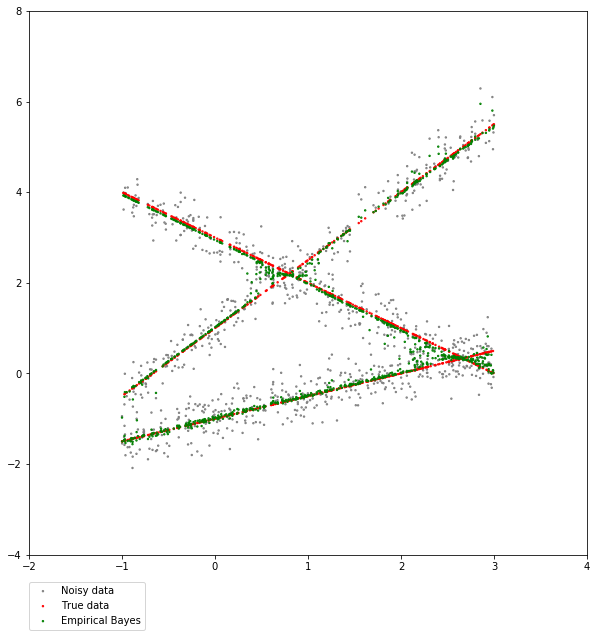

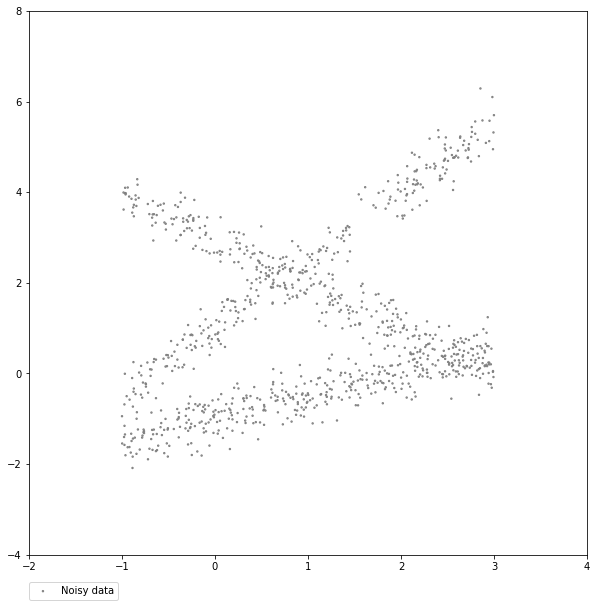

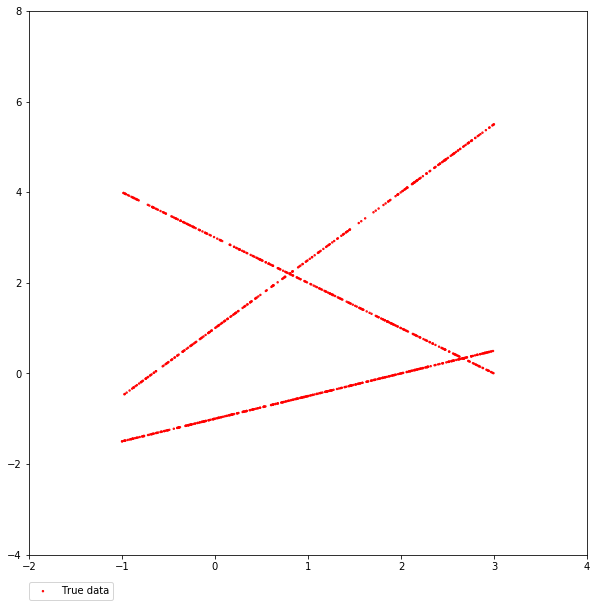

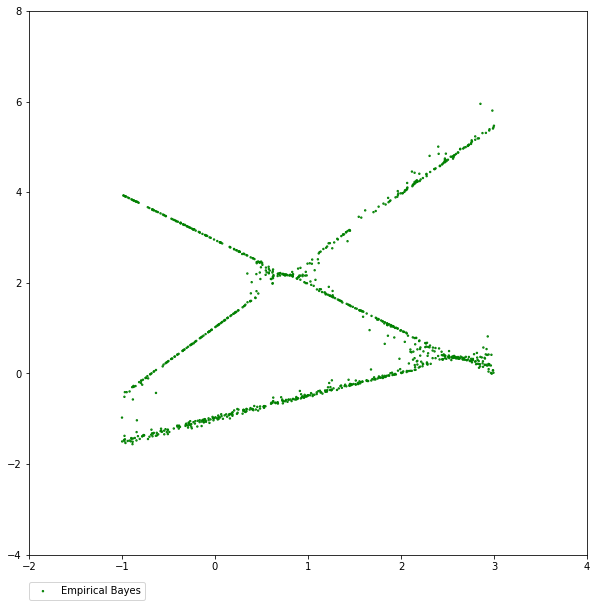

In [51]:
test_EB(1000,1500,(1,1.5),(3,-1),(-1,0.5),0.3,0.3,sigma = 0.3,sigma_est = 0.3)

beta_sol [5.40511777 9.47486922]
beta_sol [ 4.6331468  -1.57930542]
beta_sol [1.15160522 1.53492019]
beta_sol [ 4.21741886 -0.12829053]
beta_sol [0.79827168 0.18766556]
beta_sol [ 3.98696389 -1.00989175]
beta_sol [0.87068264 1.01984741]
beta_sol [1.45869778 1.14175554]
beta_sol [1.26710456 0.92029451]
beta_sol [6.93163945 7.41428869]
beta_sol [1.06539246 1.4232413 ]
beta_sol [1.07797758 1.01794803]
beta_sol [1.01170423 0.52739074]
beta_sol [ 4.43426707 -0.62254405]
beta_sol [ 4.23445197 -0.5282184 ]
beta_sol [1.08071629 1.38590949]
beta_sol [ 4.33371258 -0.69705067]
beta_sol [ 4.15734816 -1.06117844]
beta_sol [ 4.09037538 -1.03283027]
beta_sol [1.04273975 0.87351923]
beta_sol [ 4.2667647  -0.49289709]
beta_sol [ 4.27755685 -0.55155799]
beta_sol [ 4.26207466 -0.51628553]
beta_sol [1.00969912 1.39587419]
beta_sol [ 4.49959605 -0.38898429]
beta_sol [1.01599137 1.38558768]
beta_sol [0.99713684 0.9645098 ]
beta_sol [0.96400838 1.05722683]
beta_sol [ 4.26835045 -0.53254808]
beta_sol [0.99670

beta_sol [ 4.26396814 -0.52945682]
beta_sol [ 4.26341049 -0.52789461]
beta_sol [ 3.99528972 -1.01157161]
beta_sol [ 4.26353993 -0.52784525]
beta_sol [0.98568205 0.99058231]
beta_sol [0.99135834 0.99455945]
beta_sol [6.88527852 7.21704403]
beta_sol [0.92393396 1.40032544]
beta_sol [ 4.26203471 -0.52630398]
beta_sol [0.98735004 0.98958807]
beta_sol [ 3.97486238 -0.99929574]
beta_sol [0.98735837 0.98958993]
beta_sol [ 7.34864066 -5.17156133]
beta_sol [ 3.9954018  -1.01151907]
beta_sol [0.98736387 0.98959641]
beta_sol [0.9873635  0.98959607]
beta_sol [0.98828984 0.99075927]
beta_sol [ 4.00650631 -1.01515498]
beta_sol [ 4.27973591 -0.65747811]
beta_sol [ 3.99854966 -1.0111631 ]
beta_sol [ 4.26374179 -0.52796362]
beta_sol [0.9877993  0.98959864]
beta_sol [ 4.26400211 -0.52892454]
beta_sol [ 3.99769766 -1.01311687]
beta_sol [ 3.99585655 -1.01164037]
beta_sol [ 3.99586706 -1.0116478 ]
beta_sol [ 4.26372135 -0.52773987]
beta_sol [ 3.99584946 -1.01157844]
beta_sol [ 3.99587572 -1.0116231 ]
beta_

beta_sol [0.98746717 0.98990488]
beta_sol [0.98746712 0.98990491]
beta_sol [ 4.26385937 -0.52884782]
beta_sol [0.98746018 0.9898931 ]
beta_sol [ 4.03181869 -1.03119306]
beta_sol [0.98659971 0.98992643]
beta_sol [ 3.99519775 -1.01150734]
beta_sol [0.98740435 0.98977401]
beta_sol [0.99684081 1.34515635]
beta_sol [ 1.1630174  -9.48815948]
beta_sol [0.98740436 0.9897745 ]
beta_sol [6.88344385 7.2090522 ]
beta_sol [ 3.99577291 -1.01131583]
beta_sol [7.22704353 9.43163614]
beta_sol [ 4.27138855 -0.57988191]
beta_sol [ 3.99524315 -1.0116103 ]
beta_sol [1.01121243 1.35035673]
beta_sol [ 4.26347229 -0.52036171]
beta_sol [-9.44963616  5.17345404]
beta_sol [-8.6775342   4.90464088]
beta_sol [0.98739853 0.98977457]
beta_sol [1.01122961 1.35047643]
beta_sol [0.98739912 0.989774  ]
beta_sol [0.9873991  0.98977415]
beta_sol [0.99216537 0.99194902]
beta_sol [0.9876165  0.98988035]
beta_sol [1.26785883 0.82833509]
beta_sol [0.98746008 0.98991196]
beta_sol [ 3.99596295 -1.01153871]
beta_sol [1.01135718 

beta_sol [0.98637825 0.99219287]
beta_sol [0.98758836 0.99022738]
beta_sol [ 3.99495249 -1.01113175]
beta_sol [0.9977722  0.99505811]
beta_sol [ 4.25964192 -0.50489518]
beta_sol [ 3.99466586 -1.01148965]
beta_sol [0.98767298 0.99040153]
beta_sol [ 4.02105403 -1.02542603]
beta_sol [1.04679474 0.96570712]
beta_sol [ 4.01271634 -1.02285853]
beta_sol [ 3.99465084 -1.01143809]
beta_sol [ 4.26049083 -0.5259038 ]
beta_sol [0.98768283 0.99040294]
beta_sol [0.98757669 0.99042398]
beta_sol [1.01078103 1.35187593]
beta_sol [ 4.04964597 -1.0360311 ]
beta_sol [-9.21500411  5.09075583]
beta_sol [ 4.26319876 -0.52898885]
beta_sol [0.98759891 0.99022872]
beta_sol [ 4.26295886 -0.52642004]
beta_sol [ 7.36437306 -5.22587839]
beta_sol [ 3.99456576 -1.01144954]
beta_sol [ 4.26352602 -0.52879387]
beta_sol [ 3.99455571 -1.01144398]
beta_sol [ 3.94410684 -0.98638949]
beta_sol [0.98764174 0.99032383]
beta_sol [0.9875999  0.99022817]
beta_sol [ 4.26507593 -0.53122786]
beta_sol [1.01166601 1.35109659]
beta_sol 

beta_sol [0.98754841 0.99009167]
beta_sol [ 3.99414175 -1.01119112]
beta_sol [1.01716973 1.00117914]
beta_sol [0.98737497 0.99012598]
beta_sol [0.98735714 0.98953924]
beta_sol [0.98746279 0.99010692]
beta_sol [1.01110397 1.35075297]
beta_sol [ 3.99425523 -1.01141539]
beta_sol [0.9875696  0.99013613]
beta_sol [ 4.27402103 -0.54828991]
beta_sol [0.98746523 0.98989638]
beta_sol [0.98696637 0.99017779]
beta_sol [0.98736992 0.99012432]
beta_sol [0.987548   0.99009144]
beta_sol [ 3.99427001 -1.01137403]
beta_sol [0.98681216 0.99022769]
beta_sol [0.98754701 0.99009024]
beta_sol [0.98754702 0.9900901 ]
beta_sol [1.20203886 0.86963037]
beta_sol [ 4.26435843 -0.53197743]
beta_sol [ 4.26351893 -0.52911792]
beta_sol [ 4.26354883 -0.52944354]
beta_sol [ 3.99426896 -1.01141751]
beta_sol [ 4.2635171 -0.5291297]
beta_sol [0.98754533 0.99010005]
beta_sol [0.98148233 0.98592891]
beta_sol [ 4.2613667  -0.52733649]
beta_sol [ 3.99423961 -1.01140695]
beta_sol [ 4.26351152 -0.52922083]
beta_sol [ 3.99424051

beta_sol [ 3.99424693 -1.0114124 ]
beta_sol [ 3.99423258 -1.01140835]
beta_sol [0.98747097 0.98994482]
beta_sol [0.98738359 0.99022384]
beta_sol [ 3.99417148 -1.01141341]
beta_sol [ 3.99424411 -1.01140116]
beta_sol [0.98747053 0.9899429 ]
beta_sol [6.88343354 7.20922074]
beta_sol [ 3.99424242 -1.01140749]
beta_sol [0.98747009 0.98994287]
beta_sol [1.01135155 1.35036035]
beta_sol [ 3.99517759 -1.01196609]
beta_sol [0.9874703  0.98994294]
beta_sol [ 3.99425827 -1.01144877]
beta_sol [0.98747033 0.98994331]
beta_sol [ 4.26353886 -0.52929979]
beta_sol [ 3.99412324 -1.01118645]
beta_sol [0.98694316 0.98993048]
beta_sol [ 4.27073642 -0.53579301]
beta_sol [ 4.27083322 -0.5357336 ]
beta_sol [ 3.99355327 -1.01159314]
beta_sol [ 4.26353373 -0.52927951]
beta_sol [1.01135836 1.35021458]
beta_sol [ 3.99472841 -1.0115559 ]
beta_sol [ 4.26102058 -0.51780754]
beta_sol [1.01177602 0.99908094]
beta_sol [ 3.99422821 -1.01137645]
beta_sol [ 3.9931662  -1.01162893]
beta_sol [0.99691799 0.98562529]
beta_sol 

beta_sol [1.01121937 1.35108424]
beta_sol [ 4.00010326 -1.0120667 ]
beta_sol [0.98788076 0.99042707]
beta_sol [1.01115258 1.35203538]
beta_sol [ 4.26249309 -0.52609567]
beta_sol [1.01108011 1.35183185]
beta_sol [0.98790246 0.99047705]
beta_sol [ 4.2646794  -0.52580458]
beta_sol [ 3.99838648 -1.01198852]
beta_sol [1.0110656  1.35191015]
beta_sol [ 3.68032053 -0.9582899 ]
beta_sol [ 4.2647584  -0.52624999]
beta_sol [ 3.99915855 -1.01221006]
beta_sol [ 4.26468662 -0.52591595]
beta_sol [ 3.99937266 -1.01174151]
beta_sol [0.98787145 0.99040237]
beta_sol [ 3.99836405 -1.01192353]
beta_sol [ 7.49686402 -5.34017924]
beta_sol [ 4.26445207 -0.52765672]
beta_sol [0.98787143 0.99040168]
beta_sol [1.01085107 1.35252453]
beta_sol [0.98763711 0.98974422]
beta_sol [ 3.99836919 -1.01194389]
beta_sol [ 4.28323746 -0.55488984]
beta_sol [ 3.99839162 -1.0119397 ]
beta_sol [1.15519085 0.89609095]
beta_sol [ 4.2635617  -0.52659442]
beta_sol [ 4.26468395 -0.52591252]
beta_sol [ 1.16304152 -9.48785309]
beta_so

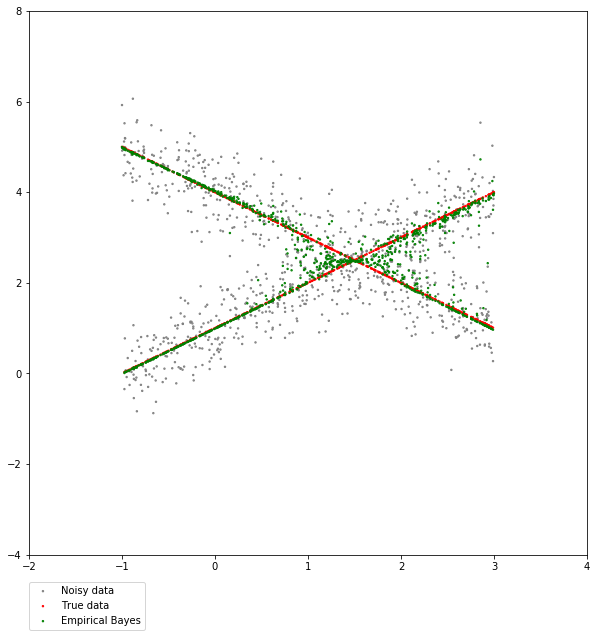

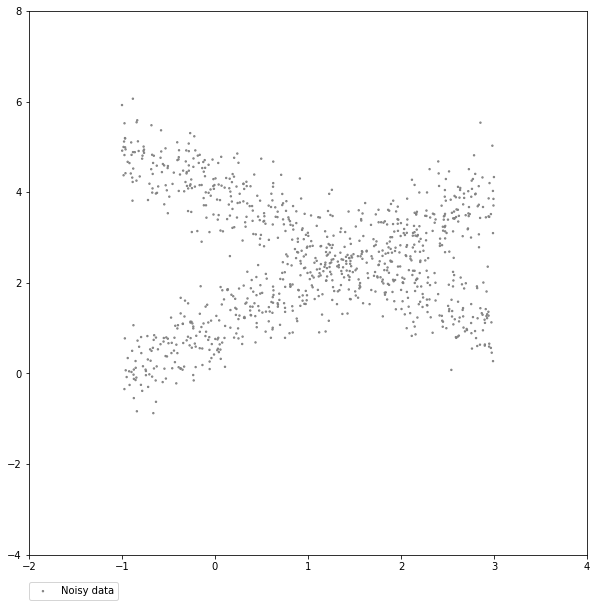

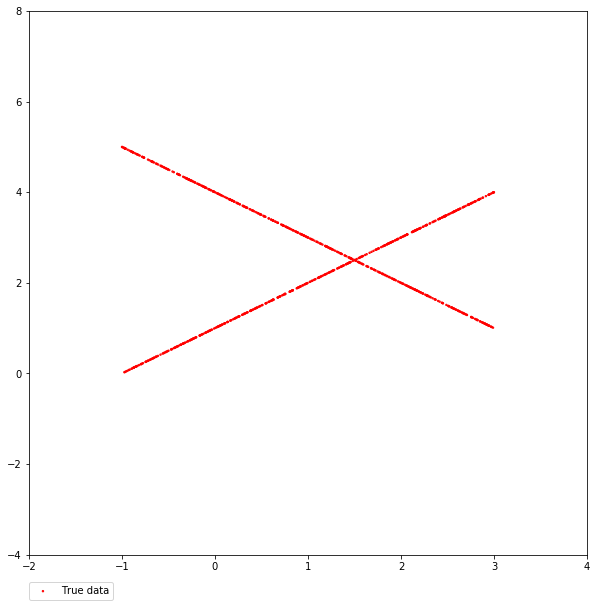

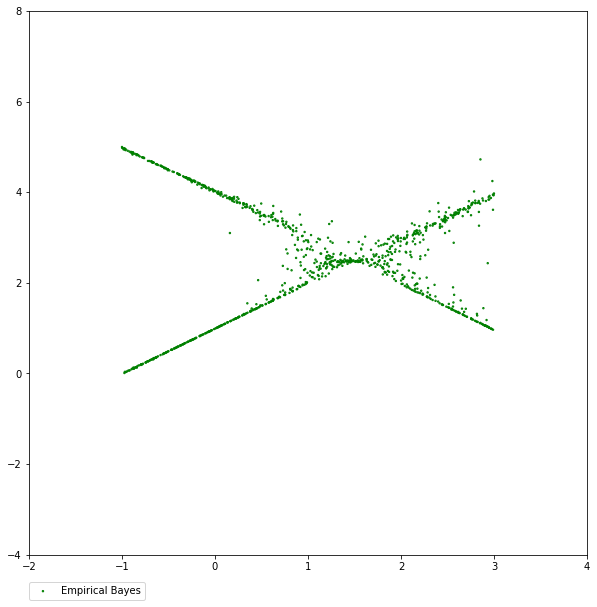

In [50]:
test_EB(1000,1500,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.5,sigma_est=0.5)

__Empirical Bayes Complicated__

In [13]:
def test_EB_complicated(n,iter, b1, b2, b3, b4, b5,pi1,pi2,pi3, pi4,sigma,sigma_est):
    '''
    plot Empirical Bayes results on 2/3 components
    
    
    '''
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    
    #parameters for generating synthetic data
    sigma1 = sigma  # variance of 1st component
    sigma2 = sigma      #variance of 2nd component
    sigma3 = sigma
    sigma4 = sigma
    sigma5 = sigma
    
    #sigma_est is what we use for Frank-Wofle method
    
    # synthesize two component data
    b1 = np.reshape(b1,(2,1))
    b2 = np.reshape(b2,(2,1))
    b3 = np.reshape(b3,(2,1))
    b4 = np.reshape(b4,(2,1))
    b5 = np.reshape(b5,(2,1))

    X = np.zeros((n,2))
    y = np.zeros((n,1))
    y_true = np.zeros((n,1))
    y_EB = np.zeros((n,1))
    
    # C denots the true class of each data point
    C = np.zeros((n,1))
    
    # set random seed
    np.random.seed(26)
    for i in range(n):
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        z = np.random.uniform(0,1)
        if z < pi1:
            y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
            y_true[i] = np.dot(X[i],b1)
            C[i] = 1
        elif z < pi1 + pi2 :
            y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
            y_true[i] = np.dot(X[i],b2)
            C[i] = 2
        elif z < pi1 + pi2 + pi3 :
            y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
            y_true[i] = np.dot(X[i],b3)
            C[i] = 3
        elif z < pi1 + pi2 + pi3 +pi4:
            y[i] = np.dot(X[i],b4) + np.random.normal(0,sigma4)
            y_true[i] = np.dot(X[i],b4)
            C[i] = 4
        else:
            y[i] = np.dot(X[i],b5) + np.random.normal(0,sigma5)
            y_true[i] = np.dot(X[i],b5)
            C[i] = 5
            
            
    #test what sigma we use
    #sigma_est = np.sqrt(pi* sigma1**2 + (1-pi)*sigma2**2)
    
    #run Frank-Wofle
    print("beta_OLS is",  np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)))
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    # calculate Empirical Bayes estimator
    N = len(B[0])
    temp0 = 0
    for i in range(n):
        temp1 = 0
        temp2 = 0
        for j in range(N):
            temp0 = np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2/(sigma**2))
            temp1 = temp1 + np.dot(X[i],B[:,j])*temp0
            temp2 = temp2 + temp0
        y_EB[i] = temp1/temp2          
        
    
    #plot
    fig = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y,color = 'grey',s = 2,marker = 'o', label = 'Noisy data', facecolors = 'None');
    plt.scatter(X[:,1],y_true,color = 'red',s = 2, marker = 'o',label = 'True data', facecolors = 'None');
    plt.scatter(X[:,1],y_EB,color = 'green',s = 2, marker = 'o',label = 'Empirical Bayes', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig1 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y,color = 'grey',s = 2,marker = 'o', label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig2 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y_true,color = 'red',s = 2, marker = 'o',label = 'True data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig3 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y_EB,color = 'green',s = 2, marker = 'o',label = 'Empirical Bayes', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();

beta_OLS is [[10.60172079]
 [-1.7366637 ]]
beta_sol [ 1.30731681 -6.57890994]


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:114: RuntimeWarning: overflow encountered in true_divide
/global/so

beta_sol [-2.76211562 -5.24640376]
beta_sol [-2.75710382 -0.86811882]
beta_sol [-3.25888256 -5.36721854]
beta_sol [-1.590919    1.81360858]
beta_sol [ 4.80582046 -7.72557533]
beta_sol [2.18406044 2.19636319]
beta_sol [-8.37957627 -7.69182667]
beta_sol [-1.22246061  1.64308219]
beta_sol [-2.81963093 -4.72677943]
beta_sol [1.16119331 0.03949332]
beta_sol [ 5.01060217 -4.73694262]
beta_sol [-6.72733009 -5.43330336]
beta_sol [ 0.63119072 -3.84900954]
beta_sol [-7.15255912  2.6692633 ]
beta_sol [-4.83978952 -6.00191363]
beta_sol [8.34552544 1.70223842]
beta_sol [ 9.92885132 -5.23562844]
beta_sol [-3.67786429 -0.26548504]
beta_sol [-9.19703666 -9.41462154]
beta_sol [-6.40551051  6.84476698]
beta_sol [2.66695473 5.57980613]
beta_sol [ 8.61846579 -0.21677191]
beta_sol [ 4.52511035 -3.25316861]
beta_sol [3.23420489 0.31359281]
beta_sol [ 2.7313136  -5.31898461]
beta_sol [-1.61124934 -1.63455054]
beta_sol [ 7.6976095  -3.04797143]
beta_sol [-9.07733618 -9.63908608]
beta_sol [-4.60339442 -6.04332

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in true_divide
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in true_divide


beta_sol [-8.27942189 -0.52625491]
beta_sol [5.81063699 0.18167011]
beta_sol [7.08087996 3.87068333]
beta_sol [-6.31864362 -8.88262072]
beta_sol [1.17753523 3.86718929]
beta_sol [-8.31853798  5.24374227]
beta_sol [-7.57856252 -9.77768618]
beta_sol [-5.2844412  -4.57775319]
beta_sol [-8.29414371  6.48568562]
beta_sol [ 1.89971814 -2.27790383]
beta_sol [-4.32853075 -6.18594462]
beta_sol [ 7.88212575 -5.03702216]
beta_sol [7.43461216 8.81519855]
beta_sol [-4.9968362  -0.93196099]
beta_sol [ 2.25967569 -6.92635154]
beta_sol [-6.52154326 -6.08105796]
beta_sol [ 8.92346991 -5.58578221]
beta_sol [-3.8916305   0.13760162]
beta_sol [-7.53340079  9.25507492]
beta_sol [-3.96792358  7.24910094]
beta_sol [-1.44223344  2.427518  ]
beta_sol [-4.84887611  2.44850797]
beta_sol [-6.60911564 -0.17213306]
beta_sol [-1.4725544  3.190685 ]
beta_sol [-2.10779804 -1.30073739]
beta_sol [ 8.76749031 -4.01448434]
beta_sol [ 9.44627104 -9.07845491]
beta_sol [ 0.62746594 -5.59064093]
beta_sol [9.49625418 7.5248198

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in multiply


beta_sol [4.64175428 8.25798338]
beta_sol [-0.92066627  2.70265057]
beta_sol [-6.94567559  4.79199305]
beta_sol [-5.81789995 -0.19857518]
beta_sol [ 2.29523486 -8.90533809]
beta_sol [-7.52963498  9.77264012]
beta_sol [7.97311939 5.61650342]
beta_sol [-0.60364332 -6.75799678]
beta_sol [-7.2028796  -1.39601073]
beta_sol [-8.97023002 -9.8154743 ]
beta_sol [1.94202629 6.49825929]
beta_sol [-8.81364999  7.17672507]
beta_sol [ 1.41092   -9.8029979]
beta_sol [ 0.46804235 -8.04428833]
beta_sol [1.27844796 7.27709929]
beta_sol [-6.14174888 -4.16874963]
beta_sol [-4.8707234   9.64368846]
beta_sol [-1.44178044 -1.63768722]
beta_sol [-1.34963712  9.43827692]
beta_sol [-7.33988845 -3.58160023]
beta_sol [-9.08509474  5.7198442 ]
beta_sol [8.34177716 7.8896196 ]
beta_sol [ 6.20012959 -0.75624751]
beta_sol [-4.82332198  2.92824081]
beta_sol [-9.37669354 -8.41775702]
beta_sol [ 6.82059631 -1.8174126 ]
beta_sol [-1.15955893  1.2866297 ]
beta_sol [-8.34685279  1.78043002]
beta_sol [-5.53158414 -6.9927216

beta_sol [-3.60727217 -1.59301862]
beta_sol [ 4.29911518 -0.60563897]
beta_sol [ 4.17502813 -8.6741258 ]
beta_sol [ 7.47211474 -4.28811734]
beta_sol [ 9.99900292 -8.2488835 ]
beta_sol [ 2.88748158 -1.75650411]
beta_sol [9.18211973 2.96555256]
beta_sol [-8.40869899 -8.22125378]
beta_sol [ 7.25253585 -8.153972  ]
beta_sol [ 6.26329517 -6.73470609]
beta_sol [8.07020499 4.84429203]
beta_sol [-9.68891329 -1.09742759]
beta_sol [-6.3928388   3.75913687]
beta_sol [-2.10080608  0.78857555]
beta_sol [-6.95318075 -8.55399911]
beta_sol [ 1.04824666 -7.89679604]
beta_sol [ 8.34556807 -9.14343059]
beta_sol [-5.0830528   5.45478063]
beta_sol [6.056829   2.89525661]
beta_sol [0.64413765 6.8609483 ]
beta_sol [ 5.85726128 -6.3483791 ]
beta_sol [5.23255488 4.3022816 ]
beta_sol [2.76897127 4.28973122]
beta_sol [ 8.59054607 -6.64035877]
beta_sol [-3.98386794 -4.16055565]
beta_sol [7.44140591 4.21324102]
beta_sol [-3.97624198  0.8052866 ]
beta_sol [ 9.78134676 -6.12743159]
beta_sol [-3.80874225  3.46377187]

/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


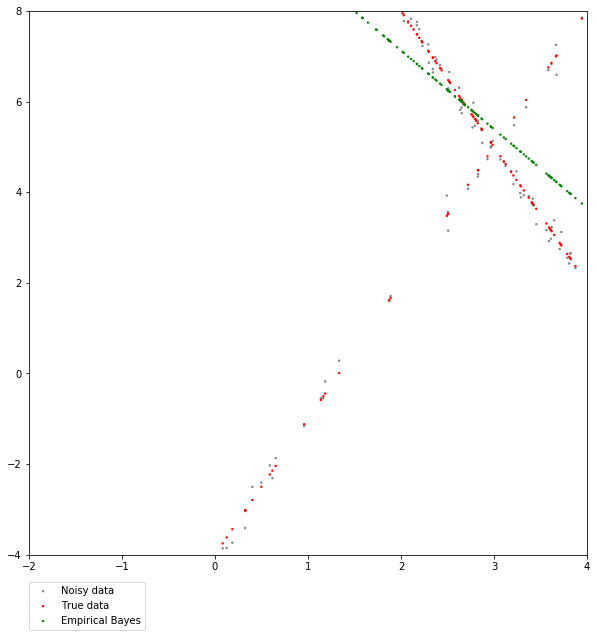

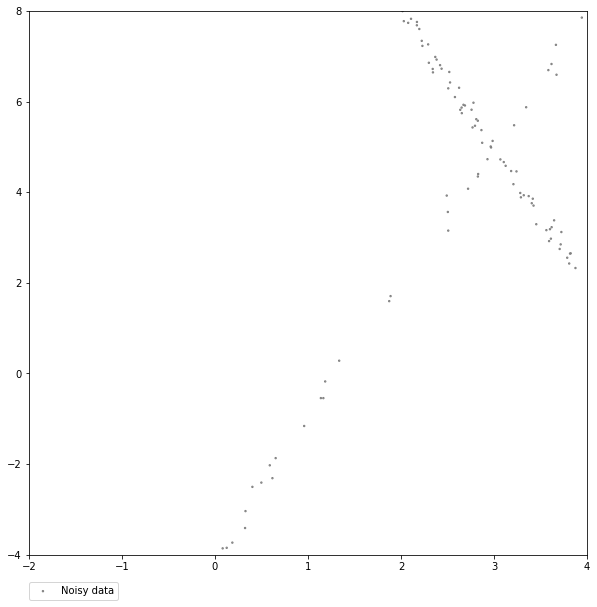

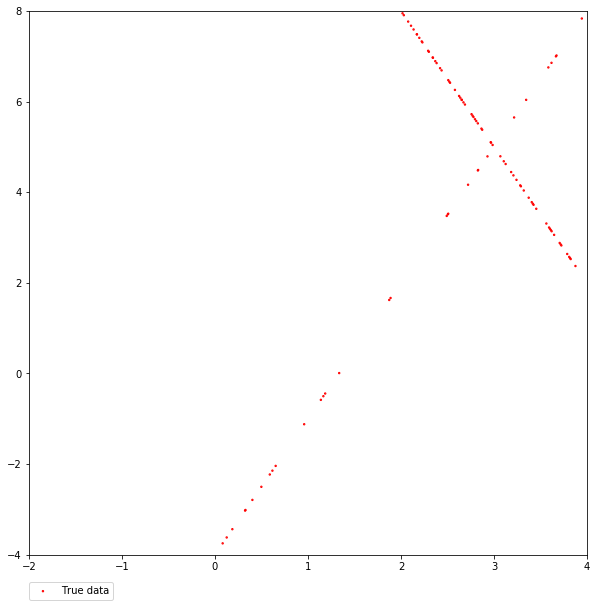

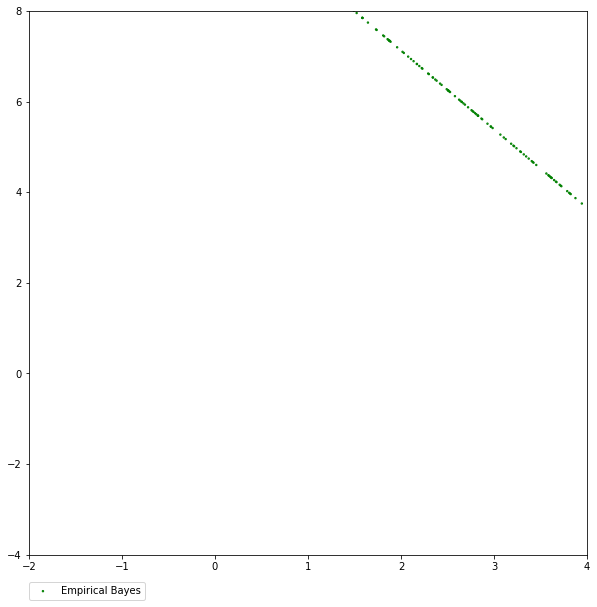

In [8]:
test_EB_complicated(500, 500, (-4,3), (14,-3), (0,2),(0.75,-0.625),(-3,0.625),0.2,0.8,0.2, 0.2,sigma = 0.2,sigma_est =0.2)

In [ ]:
test_EB_complicated(500, 1000, (-2,1), (2,1), (2,-1),(-2,-1),(-3,0.625),0.25,0.25,0.25,0.25,sigma = 0.2,sigma_est =0.2)

beta_OLS is [[0.00160384]
 [0.03393363]]


/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:2598: RuntimeWarning: overflow encountered in double_scalars
  t *= temp*temp
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:2600: RuntimeWarning: overflow encountered in double_scalars
  t -= delta*temp*temp
/global/software/sl-7.x86_64/modules/langs/python/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:2600: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp


beta_sol [14.34242364 -6.56449504]
beta_sol [-1.26169265 -5.24865899]
beta_sol [-2.67730168 -0.86794606]
beta_sol [20.73053597 -5.32592341]
beta_sol [0.0836662  1.81281788]
beta_sol [ 0.91766525 -7.6974438 ]
beta_sol [2.26547278 2.20281263]
beta_sol [-10.11705247  -7.69617329]
beta_sol [-2.91130238  1.64387989]
beta_sol [-1.9014073  -4.72426007]
beta_sol [2.79763543 0.28493753]
beta_sol [ 6.85351854 -4.72872152]
beta_sol [-7.29980793 -5.43135426]
beta_sol [ 1.93052125 -1.04105915]
beta_sol [-6.80299695  2.66837353]
beta_sol [-4.71227536 -6.00144366]
beta_sol [-0.87566153  1.86728206]
beta_sol [ 9.70778853 -7.7497531 ]
beta_sol [-1.18104531 -0.33436348]
beta_sol [-6.89748683 -9.41328204]
beta_sol [-7.03862008  4.78909172]
beta_sol [-5.05299354  5.21612612]
beta_sol [1.95131263 1.17578657]
beta_sol [-1.85919125 -0.94890284]
beta_sol [1.76877615 1.02729608]
beta_sol [ 1.10347425 -2.21126243]
beta_sol [-1.17238411 -1.3987622 ]
beta_sol [ 7.73327149 -2.85100065]
beta_sol [-8.2316563  -9.633

beta_sol [ 3.56916297 -3.23213942]
beta_sol [-2.43992096 -6.65732808]
beta_sol [0.09580371 7.67499392]
beta_sol [-7.74009593  8.56230233]
beta_sol [-3.29648536  8.69087386]
beta_sol [-1.94618067  1.1185733 ]
beta_sol [ 1.74732142 -2.45105114]
beta_sol [-5.27043495  5.05552335]
beta_sol [-16.81443597   8.16589715]
beta_sol [ 3.56945103 -3.23240438]
beta_sol [16.86593491 -6.51285241]
beta_sol [-2.00195291  1.0237039 ]
beta_sol [-4.94919432 -6.60815398]
beta_sol [ 0.07315954 -6.44787364]
beta_sol [ 9.55548086 -5.88739576]
beta_sol [ 5.918129   -7.92803817]
beta_sol [ 5.97409189 -4.88692892]
beta_sol [-7.17116547 -7.74302805]
beta_sol [-4.48158133  4.59905685]
beta_sol [1.25723798 1.48522952]
beta_sol [0.09562472 7.67597196]
beta_sol [ 8.3369196  -3.21461737]
beta_sol [-6.22599394  5.5734089 ]
beta_sol [0.09544709 7.67419675]
beta_sol [-3.68318613  1.92550806]
beta_sol [ 6.2372068  -2.38483263]
beta_sol [-13.30033755   6.596219  ]
beta_sol [ 1.74682427 -2.45100253]
beta_sol [1.25719461 1.4

In [ ]:
test_EB_complicated(500, 500, (-2,1), (2,-1), (2,-1),(-2,-1),(-3,0.625),0.25,0.25,0.25, 0.25,sigma = 0.2,sigma_est =0.2)

beta_OLS is [[-0.01290718]
 [-0.52504811]]
beta_sol [ 1.30731681 -6.57890994]
beta_sol [-2.76211562 -5.24640376]
beta_sol [-2.30713099 -1.01076326]
beta_sol [-3.25888256 -5.36721854]
beta_sol [-1.26908522  2.77096067]
beta_sol [ 5.11291729 -7.61455044]
beta_sol [2.18406044 2.19636319]
beta_sol [-8.12023454 -7.88044918]
beta_sol [-1.22246061  1.64308219]
beta_sol [-2.81963093 -4.72677943]
beta_sol [1.16119331 0.03949332]
beta_sol [ 5.01060217 -4.73694262]
beta_sol [-6.33146674 -5.73685565]
beta_sol [ 0.63119072 -3.84900954]
beta_sol [-7.11651183  2.76961038]
beta_sol [-4.70697531 -6.17832746]
beta_sol [8.34552544 1.70223842]
beta_sol [ 9.92885132 -5.23562844]
beta_sol [-3.59087019 -0.07379902]
beta_sol [ -8.39898437 -10.03366318]
beta_sol [-6.40551051  6.84476698]
beta_sol [2.66695473 5.57980613]
beta_sol [ 8.61846579 -0.21677191]
beta_sol [ 4.52511035 -3.25316861]
beta_sol [3.23420489 0.31359281]
beta_sol [ 2.7313136  -5.31898461]
beta_sol [-1.45069611 -0.84230223]
beta_sol [ 7.6976095

beta_sol [-2.57060737  5.44627088]
beta_sol [-2.21644738 -4.48203024]
beta_sol [  8.62965028 -19.82236866]
beta_sol [1.76626385 8.13815737]
beta_sol [-8.85100042  9.76653778]
beta_sol [-1.47160204  9.72884886]
beta_sol [-9.24655702  4.43004068]
beta_sol [-9.83010977 -2.56433642]
beta_sol [-5.3670324   6.77772007]
beta_sol [1.95035596 8.55928518]
beta_sol [ 4.44594862 -3.9154817 ]
beta_sol [-2.07911566 -9.6577134 ]
beta_sol [-2.39408523  2.75633173]
beta_sol [-4.97504389 -6.68550548]
beta_sol [ 0.0526719 -6.7852977]
beta_sol [ 7.30985979 -5.25007644]
beta_sol [ 5.32675997 -9.65998537]
beta_sol [ 6.42103563 -6.22139098]
beta_sol [  7.5426811 -21.083075 ]
beta_sol [-6.33121426  7.23616206]
beta_sol [2.20381452 1.7810412 ]
beta_sol [7.85931683 8.58622931]
beta_sol [ 7.67445138 -8.62717942]
beta_sol [-0.47698932  9.64900942]
beta_sol [0.46136363 8.81018623]
beta_sol [9.74708198 2.28848071]
beta_sol [ 4.63270108 -2.66475329]
beta_sol [5.50794599 6.71254414]
beta_sol [ 2.52708025 -2.37535936]

__Empirical Bayes Continuous__

In [9]:
def test_EB_continuous(n,iter, pi1, sigma,sigma_est):
    '''
    plot Empirical Bayes results on 2/3 components
    
    
    '''
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    #sigma = 0.8 # standard deviation
    threprob = 0.02
    #pi1 = 0.5 # first componrnt has probability pi
    #pi2 = 0.25
    
    
    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    y_true = np.zeros((n,1))
    y_EB = np.zeros((n,1))
    
    
    np.random.seed(26)
    for i in range(n):
        b_pi = np.random.uniform(0,1)
        
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        meanb1 = [1,1]
        covb1 = [[0.01,0],[0,0.02]]
        meanb2 = [2,2]
        covb2 = [[0.01,0],[0,0.02]]
        b1 = np.reshape(np.random.multivariate_normal(meanb1,covb1,1),(2,1))
        b2 = np.reshape(np.random.multivariate_normal(meanb2,covb2,1),(2,1))

        '''
    
        b1 = np.random.beta(2,6,size = (2,1))
        b2 = np.array([[1],[0.5]])+np.random.beta(2,2,size = (2,1))
        '''
        if b_pi < pi1:
            b = b1
        else:
            b = b2
        y[i] = np.dot(X[i],b) + np.random.normal(0,sigma)
        y_true[i] =  np.dot(X[i],b)
    
    #run Frank-Wofle
    print("beta_OLS is",  np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1)))
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    # calculate Empirical Bayes estimator
    N = len(B[0])
    temp0 = 0
    for i in range(n):
        temp1 = 0
        temp2 = 0
        for j in range(N):
            temp0 = np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2/(sigma**2))
            temp1 = temp1 + np.dot(X[i],B[:,j])*temp0
            temp2 = temp2 + temp0
        y_EB[i] = temp1/temp2          
        
    
    #plot
    fig = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y,color = 'grey',s = 2,marker = 'o', label = 'Noisy data', facecolors = 'None');
    plt.scatter(X[:,1],y_true,color = 'red',s = 2, marker = 'o',label = 'True data', facecolors = 'None');
    plt.scatter(X[:,1],y_EB,color = 'green',s = 2, marker = 'o',label = 'Empirical Bayes', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig1 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y,color = 'grey',s = 2,marker = 'o', label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig2 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y_true,color = 'red',s = 2, marker = 'o',label = 'True data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    fig3 = plt.figure(figsize = (10,10))
    plt.scatter(X[:,1],y_EB,color = 'green',s = 2, marker = 'o',label = 'Empirical Bayes', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-3,9])
    ax.set_ylim([-4,8])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();

beta_OLS is [[1.5002979 ]
 [1.45607874]]
beta_sol [8.15937601 0.21466651]
beta_sol [-9.40933692  3.85420688]
beta_sol [11.7016479  -4.64231248]
beta_sol [-0.09604907  1.13607934]
beta_sol [4.1893835  1.18416812]
beta_sol [2.57033883 1.66376544]
beta_sol [1.67311209 2.63527736]
beta_sol [0.95270595 1.10205946]
beta_sol [1.00669662 0.36140711]
beta_sol [1.63673997 2.16518903]
beta_sol [2.10775586 2.37427845]
beta_sol [1.44263094 0.53003919]
beta_sol [2.02131022 2.43199258]
beta_sol [2.21269198 1.57517305]
beta_sol [1.30057786 0.07524209]
beta_sol [2.17700263 1.88677386]
beta_sol [1.38196218 2.68676393]
beta_sol [1.01314874 1.49224669]
beta_sol [2.15491604 1.61471747]
beta_sol [1.94953936 1.9637903 ]
beta_sol [1.39320158 2.61660098]
beta_sol [1.02459783 0.83070558]
beta_sol [1.42011275 2.27539075]
beta_sol [2.09300244 1.9102892 ]
beta_sol [-13.73636828   6.76029872]
beta_sol [1.20893604 0.81466443]
beta_sol [-5.14021339  2.87049248]
beta_sol [2.04103714 1.93737841]
beta_sol [1.42948906 2.

beta_sol [2.09219186 1.90057236]
beta_sol [1.4470237  2.26562188]
beta_sol [1.36464131 0.2894747 ]
beta_sol [2.05600601 1.92729579]
beta_sol [1.4213628  2.27922937]
beta_sol [0.97152481 1.21057274]
beta_sol [1.423511   2.27728005]
beta_sol [1.34386232 2.68314818]
beta_sol [-2.86894783  4.54365705]
beta_sol [1.36445084 0.28871783]
beta_sol [1.420218   2.27980908]
beta_sol [1.36339795 0.28896216]
beta_sol [-13.36831571   6.59025051]
beta_sol [0.97661533 1.18748056]
beta_sol [1.45118654 2.2764592 ]
beta_sol [-5.50960484  3.03934489]
beta_sol [ 8.53572869 -3.31661028]
beta_sol [0.97629725 1.19759324]
beta_sol [1.3983494  2.65391736]
beta_sol [1.06611677 0.88478583]
beta_sol [2.3278713  1.44454264]
beta_sol [1.06550357 0.88841738]
beta_sol [1.42302578 2.27852645]
beta_sol [1.06185993 0.88893359]
beta_sol [1.36485639 0.28918882]
beta_sol [1.39823974 2.65494901]
beta_sol [2.05160251 1.93180569]
beta_sol [2.06731606 1.92001159]
beta_sol [ 5.74434656 -2.03970765]
beta_sol [2.09398832 1.90786368

beta_sol [1.52375712 2.2254204 ]
beta_sol [1.36432165 0.28839729]
beta_sol [0.97757281 1.14955074]
beta_sol [0.93500862 1.49801116]
beta_sol [0.97500789 1.20194827]
beta_sol [1.39853416 2.65577212]
beta_sol [1.39849687 2.65603123]
averge beta is  [[1.49537683]
 [1.46836399]]
training error is  1.5878359306431342
beta_ols [[1.5002979 ]
 [1.45607874]]
final neg log likelihood is  649.7762203727364
number of components is 324
only components with probability at least  0.02  are shown below:


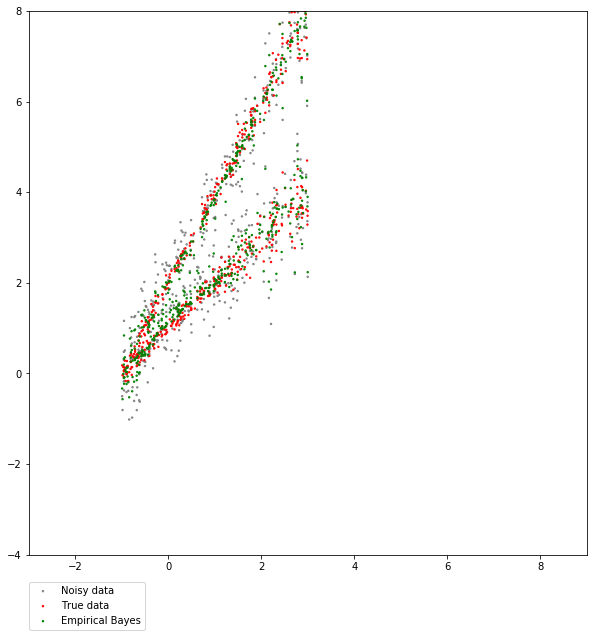

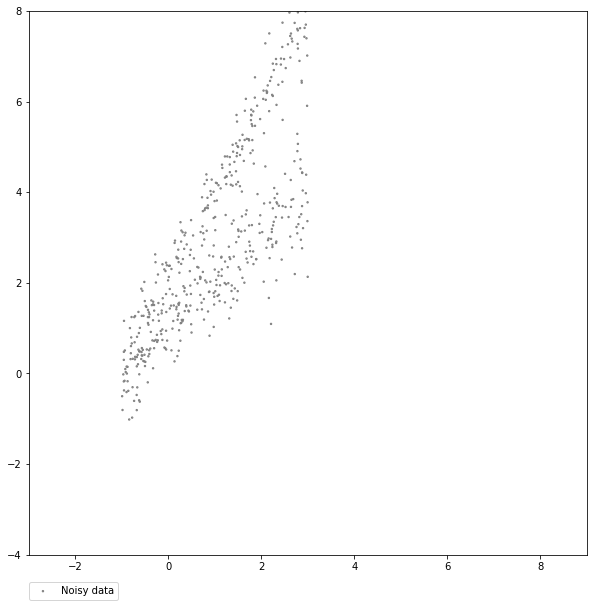

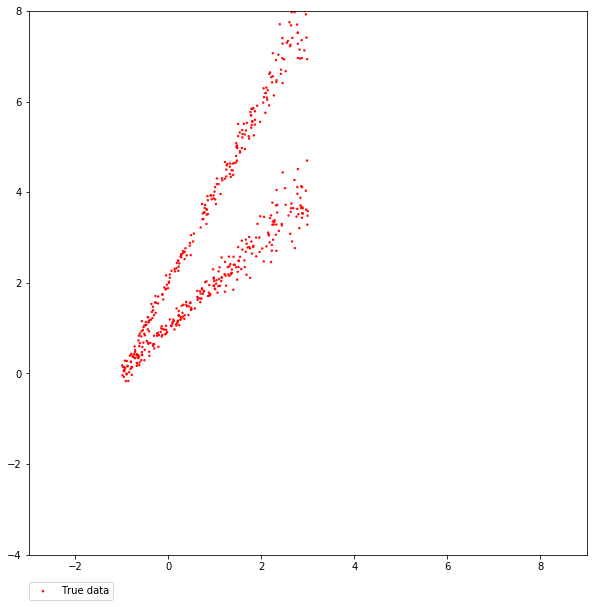

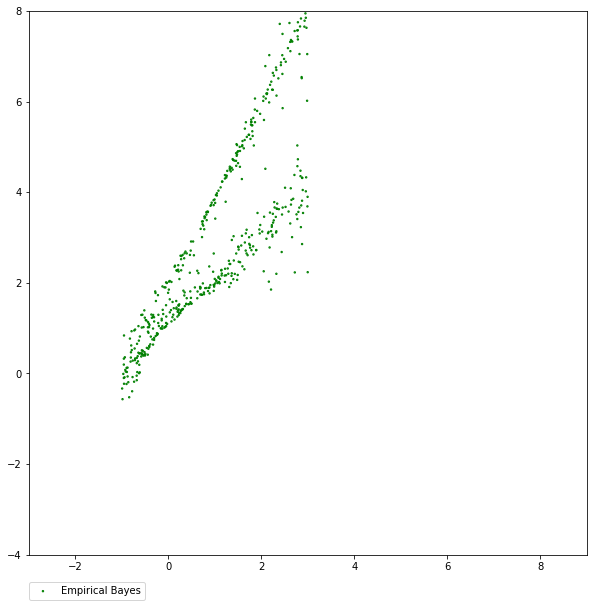

In [11]:
test_EB_continuous(500,500, 0.5, 0.5,0.5)

__Sigma Choice__

In [ ]:
n = 150
p =2    #number of components (currently we only consider 2 component)
sigma = 0.2 # standard deviation
probthre = 1e-2
pi = 0.5 # first componrnt has probability pi

sigma1 = sigma  # variance of 1st component
sigma2 = sigma      #variance of 2nd component

# synthesize two component data
b1 = np.reshape([1,1],(2,1))
b2 = np.reshape([4,-1],(2,1))

X = np.zeros((n,2))
y = np.zeros((n,1))
for i in range(n):
    X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
    z = np.random.uniform(0,1)
    if z < pi:
        y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
    else:
        y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)


In [ ]:
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 0.1
sigma_list = np.sqrt(np.arange(sigma_min**2, sigma_max**2, 0.06**2))
number = len(X)
#random permutation to shuffle data
index = np.random.permutation(number)

X_shuffled = X[index]
y_shuffled = y[index]

In [ ]:
L_sigma_rec_synthetic(500,300, (1,1), (4,-1),0.6)

__5 fold cross validation__

In [ ]:
L_sigma_rec,train_error_sigma_rec, test_error_sigma_rec = L_sigma(X_shuffled[:120],y_shuffled[:120],X_shuffled[120:150],y_shuffled[120:150],sigma_list)
L_sigma_rec2,train_error_sigma_rec2, test_error_sigma_rec2 = L_sigma(X_shuffled[30:150],y_shuffled[30:150],X_shuffled[:30],y_shuffled[:30],sigma_list)
L_sigma_rec3,train_error_sigma_rec3, test_error_sigma_rec3 = L_sigma(np.append(X_shuffled[:30], X_shuffled[60:150],axis = 0),np.append(y_shuffled[:30], y_shuffled[60:150],axis = 0),X_shuffled[30:60],y_shuffled[30:60],sigma_list)
L_sigma_rec4,train_error_sigma_rec4, test_error_sigma_rec4 = L_sigma(np.append(X_shuffled[:60], X_shuffled[90:150],axis = 0),np.append(y_shuffled[:60], y_shuffled[90:150],axis = 0),X_shuffled[60:90],y_shuffled[60:90],sigma_list)
L_sigma_rec5,train_error_sigma_rec5, test_error_sigma_rec5 = L_sigma(np.append(X_shuffled[:90], X_shuffled[120:150],axis = 0),np.append(y_shuffled[:90], y_shuffled[120:150],axis = 0),X_shuffled[90:120],y_shuffled[90:120],sigma_list)
L_sigma_rec_CV = np.zeros((len(sigma_list),1))
L_sigma_rec_CV = np.array(L_sigma_rec)+np.array(L_sigma_rec2)+ np.array(L_sigma_rec3)+ np.array(L_sigma_rec4)+ np.array(L_sigma_rec5)
train_error_sigma_rec_CV = np.zeros((len(sigma_list),1))
train_error_sigma_rec_CV = np.array(train_error_sigma_rec) + np.array(train_error_sigma_rec2) + np.array(train_error_sigma_rec3) + np.array(train_error_sigma_rec4) + np.array(train_error_sigma_rec5)
train_error_sigma_rec_CV = train_error_sigma_rec_CV/5
fig1 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, L_sigma_rec_CV);plt.title("5-fold CV neg-log likelihood");
    
fig2 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, train_error_sigma_rec_CV);plt.title("5-fold CV taining error");
    
fig3 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, test_error_sigma_rec_CV);plt.title("5-fold CV validation error");

__Hellinger risk scaling wrt n__

In [ ]:
#test function with synthetic data
def hellinger_risk(n,num,iter, b1, b2, b3,pi1,pi2,sigma,sigma_est):
    '''
    Return the average risk on #num random experiments
    
    '''

    hellinger_rec = []
    
    for j in range(num):
        
        p =2    #number of components (currently we only consider 2 component)
        #sigma = 0.8 # standard deviation
        threprob = 0.02
        #pi1 = 0.5 # first componrnt has probability pi
        #pi2 = 0.25


        #parameters for generating synthetic data
        sigma1 = sigma  # variance of 1st component
        sigma2 = sigma      #variance of 2nd component
        sigma3 = sigma

        #sigma_est is what we use for Frank-Wofle method

        # synthesize two component data
        b1 = np.reshape(b1,(2,1))
        b2 = np.reshape(b2,(2,1))
        b3 = np.reshape(b3,(2,1))

        X = np.zeros((n,2))
        y = np.zeros((n,1))

        # C denots the true class of each data point
        C = np.zeros((n,1))

        for i in range(n):
            X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
            z = np.random.uniform(0,1)
            if z < pi1:
                y[i] = np.dot(X[i],b1) + np.random.normal(0,sigma1)
                C[i] = 1
            elif z < pi1 + pi2 :
                y[i] = np.dot(X[i],b2) + np.random.normal(0,sigma2)
                C[i] = 2
            else:
                y[i] = np.dot(X[i],b3) + np.random.normal(0,sigma3)
                C[i] = 3

        f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
        hellinger = 0
        for i in range(n):
            x = X[i][1]           

            #calculate difference of suqre root of density functions
            dist_fit = lambda y: (np.sqrt(0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x), 0, sigma)+0.5*scipy.stats.norm.pdf(y-(b1[0]+b1[1]*x),0, sigma)) \
            - np.sqrt(sum(alpha[i]*scipy.stats.norm.pdf( y - (B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha)))))**2

            hellinger = hellinger + quad(dist_fit, -np.inf, np.inf)[0]
        hellinger_rec.append(hellinger/n)
    return hellinger_rec
        

In [ ]:
hellinger_rec = hellinger_risk(50,5,20,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8)

In [ ]:
hellinger_n_rec = []
for n in np.arange(50,100,10):
    hellinger_n_rec.append(np.sum(hellinger_risk(50,5,20,(1,1),(4,-1),(-1,0.5),0.5,0.5,sigma = 0.8,sigma_est=0.8))/5)

__Continuous Measure__

In [6]:
sigma = 0.3
meanb1 = [1,1]
covb1 = [[0.01,0],[0,0.02]]
meanb2 = [2,2]
covb2 = [[0.01,0],[0,0.02]]

from scipy import integrate

'''
# density function under continuous measure
def func_xy(x,y):
    func = lambda b,k: scipy.stats.norm.pdf(y - (b+k*x), 0, sigma)*(0.5*scipy.stats.norm.pdf(b, meanb1[0], np.sqrt(covb1[0][0]))*\
                                                            scipy.stats.norm.pdf(k, meanb1[1], np.sqrt(covb1[1][1]))+ 0.5*scipy.stats.norm.pdf(b, meanb2[0], np.sqrt(covb2[0][0]))\
                                                           *scipy.stats.norm.pdf(k, meanb2[1], np.sqrt(covb2[1][1])))
    return func
'''

# density function under continuous measure
def func_xy_b1(x,y):
    func = lambda b,k: 1/(np.sqrt(2*np.pi)**3 *sigma * np.sqrt(0.01*0.02)) *np.exp(-0.5*(y-b-k*x)**2/sigma**2)*0.5*np.exp(-0.5*(b - 1)**2/0.01)*np.exp(-0.5*(k - 1)**2/0.02)
    return func
def func_xy_b2(x,y):
    func = lambda b,k: 1/(np.sqrt(2*np.pi)**3 *sigma * np.sqrt(0.01*0.02)) *np.exp(-0.5*(y-b-k*x)**2/sigma**2)*0.5*np.exp(-0.5*(b - 2)**2/0.01)*np.exp(-0.5*(k - 2)**2/0.02)
    return func

In [6]:
#test function with synthetic data
def test_continuous(n,iter,pi1):
    # n : number of samples
    # iter : number of iterations in Frank-Wofle method
    
    #set parameters
    p =2    #number of components (currently we only consider 2 component)
    sigma = 0.3 # standard deviation
    threprob = 0.02   
    
    #sigma_est is what we use for Frank-Wofle method
    #one guess is to use the std of y
    sigma_est = sigma
    
    X = np.zeros((n,2))
    y = np.zeros((n,1))
    
    np.random.seed(26)
    for i in range(n):
        b_pi = np.random.uniform(0,1)
        
        X[i] = np.reshape([1,np.random.uniform(-1,3)],(1,2))
        meanb1 = [1,1]
        covb1 = [[0.01,0],[0,0.02]]
        meanb2 = [2,2]
        covb2 = [[0.01,0],[0,0.02]]
        b1 = np.reshape(np.random.multivariate_normal(meanb1,covb1,1),(2,1))
        b2 = np.reshape(np.random.multivariate_normal(meanb2,covb2,1),(2,1))

        '''
    
        b1 = np.random.beta(2,6,size = (2,1))
        b2 = np.array([[1],[0.5]])+np.random.beta(2,2,size = (2,1))
        '''
        if b_pi < pi1:
            b = b1
        else:
            b = b2
        y[i] = np.dot(X[i],b) + np.random.normal(0,sigma)
    
    
    #run Frank-Wofle
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma_est)
    
    
    beta_ave = np.matmul(B,alpha)
    print("averge beta is ", beta_ave)
    print("training error is ",train_error(X,y,B,alpha) )

    beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))
    print("beta_ols",beta_ols)
    #index = np.argwhere(alpha.ravel() == np.amax(alpha.ravel()))
    
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")
    
    
    fig_raw = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,18])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);
    plt.show();
    
    
    fig1 = plt.figure(figsize = (8,8))

    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
    
    
    #plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
    
    N = len(alpha)
    
    RGB_tuples = [(240,163,255),(0,117,220),(153,63,0),(76,0,92),(0,92,49),
    (43,206,72),(255,204,153),(128,128,128),(148,255,181),(143,124,0),(157,204,0),
    (194,0,136),(0,51,128),(255,164,5),(255,168,187),(66,102,0),(255,0,16),(94,241,242),(0,153,143),
    ( 224,255,102),(116,10,255),(153,0,0),(255,255,128),(255,255,0),(25,25,25),(255,80,5)]
    
    component_plot = []
    component_color = []
    
    temp = 0
    index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sorted:
        b = B[:,i]
        if alpha[i] >threprob:
            component_plot.append(i)
            component_color.append(temp)
            plt.plot(t,b[0]+b[1]*t, color = tuple( np.array(RGB_tuples[temp])/255),linewidth = alpha[i][0]*8,label = 'y = %7f + %.7f x with prob %.2f' %(b[0], b[1], alpha[i]) )
            temp = temp + 1
            print("coefficients", b, "with probability", alpha[i])
    
    # we ONLY do clustering based on plotted components, i.e. components with high probability (>threprob)
    C_cluster = np.zeros((n,1))
    for i in range(len(y)):
        prob = np.zeros((N,1))
        for j in component_plot:
            prob[j] = alpha[j] * np.exp(-0.5*(y[i] - np.dot(X[i],B[:,j]))**2 /(sigma**2))
        C_cluster[i] = np.argmax(prob)
        plt.scatter(X[i][1],y[i],color = tuple(np.array(RGB_tuples[component_color[component_plot.index(C_cluster[i])]])/255) ,marker = 'o', facecolors = 'None'); 
    ax = plt.gca()
    ax.set_xlim([-2,4])
    ax.set_ylim([-3,18])
    plt.legend(loc=2, bbox_to_anchor=(0., -0.05),borderaxespad=0.);    
    plt.show();
    
    #plot Hellinger distance
    fig2 = plt.figure(figsize = (20,3))
    x_list = [-3,-1,1, 3,5] #List of x values
    i = 0
    
    for i in range(len(x_list)):
        x = x_list[i]
        y = np.linspace(-15,15,100)
        z = np.zeros(len(y))
        for j in range(len(z)):
            if pi1 < 1:
                z[j] = integrate.dblquad(func_xy_b1(x,y[j]),-np.inf,np.inf,lambda b:-np.inf,lambda b :np.inf)[0]\
                +integrate.dblquad(func_xy_b2(x,y[j]),-np.inf,np.inf,lambda b: -np.inf,lambda b :np.inf)[0]
            else:
                 z[j] = integrate.dblquad(func_xy_b1(x,y[j]),-np.inf,np.inf,lambda b:-np.inf,lambda b :np.inf)[0]
        plt.subplot(1,len(x_list),i+1)
        plt.plot(y,z,'red',label = 'True distribution')
        plt.plot(y, sum(alpha[i]*scipy.stats.norm.pdf( y-(B[0,i]+B[1,i]*x), 0, sigma) for i in range(len(alpha))),'black',label = 'NPMLE distribution')
        #plt.plot(y, scipy.stats.norm.pdf(y-(beta_ols[0]+beta_ols[1]*x), 0, sigma),'green',label = 'OLS distribution')  
        plt.title("x = %.1f"%x)
    custom_lines = [
                Line2D([0], [0], color= 'red'),
                Line2D([0], [0], color='black'),
                #Line2D([0], [0], color='green')#
        ]
    plt.legend(custom_lines, ['True mixture', 'Fitted mixture'#, 'OLS'#
                             ], loc=2, bbox_to_anchor=(1.05, 1),borderaxespad=0.)
    plt.show()
    
    fig3 = plt.figure(figsize = (6,5))
    plt.plot(L_rec);plt.title("neg-log likelihood over iterations");
      

beta_sol [4.55085557 1.45888429]
beta_sol [ 3.07858704 -0.12317605]
beta_sol [2.98083529 1.50423687]
beta_sol [ 2.33799513 -1.28257237]
beta_sol [2.34578192 0.62684131]
beta_sol [ 1.98785538 -0.15742427]
beta_sol [0.46971144 1.13843798]
beta_sol [2.00298925 2.20254171]
beta_sol [2.12774964 1.60170077]
beta_sol [1.05910787 1.27813099]
beta_sol [2.02896    1.93326501]
beta_sol [1.63131004 2.62769771]
beta_sol [1.22652041 0.50304496]
beta_sol [2.268308  1.5852227]
beta_sol [2.20155983 1.59108277]
beta_sol [2.22362501 1.59309787]
beta_sol [2.21336413 1.59157373]
beta_sol [2.21298091 1.59234507]
beta_sol [2.21300351 1.5926668 ]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
beta_sol [2.21300347 1.59266676]
averge beta is  [[1.4354908 ]
 [1.51131

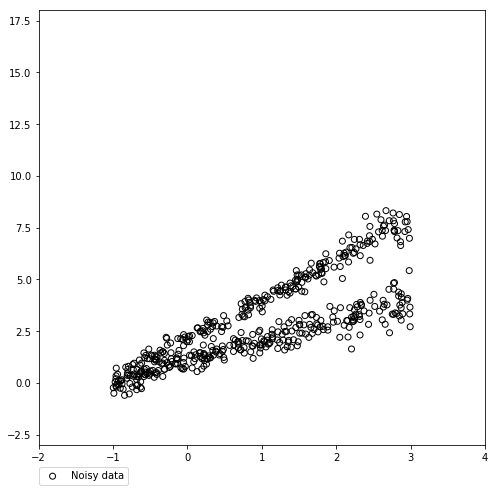

coefficients [2.02896    1.93326501] with probability [0.3617284]
coefficients [1.05910787 1.27813099] with probability [0.25829836]
coefficients [0.46971144 1.13843798] with probability [0.17855014]
coefficients [1.22652041 0.50304496] with probability [0.08436841]
coefficients [2.00298925 2.20254171] with probability [0.07200984]
coefficients [2.21336413 1.59157373] with probability [0.03936021]


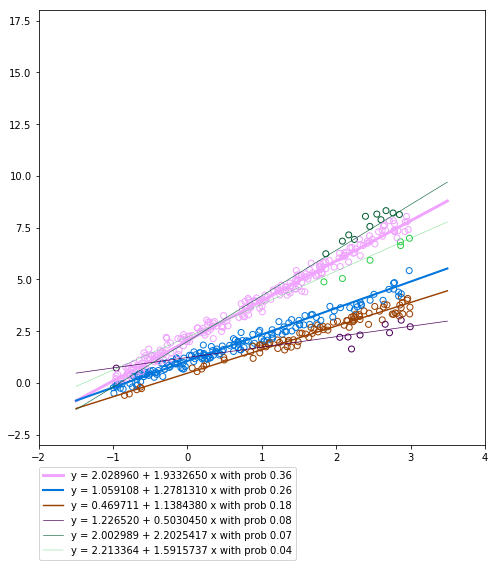

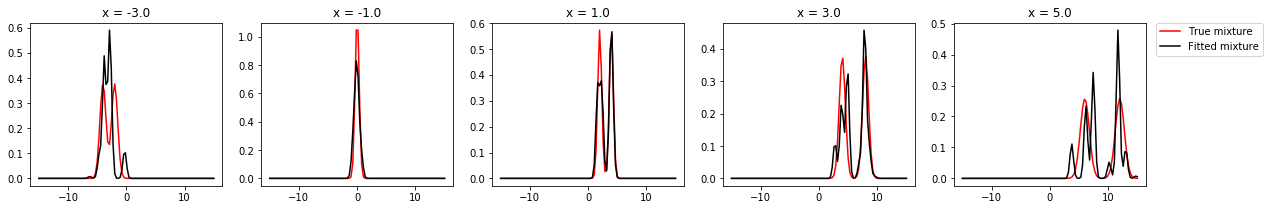

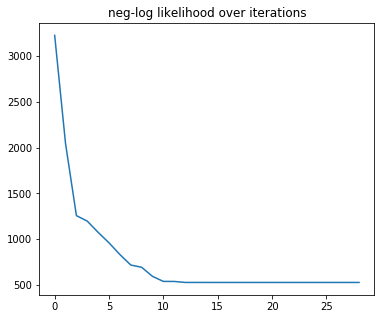

In [16]:
test_continuous(500,30,0.5)

beta_sol [ 9.44450626 -2.24790838]
beta_sol [-8.8654937   4.76181607]
beta_sol [-10.49253291   7.74538173]
beta_sol [1.89864253 2.28101518]
beta_sol [ 8.16434509 -5.01164207]
beta_sol [0.0365753  1.32313531]
beta_sol [-0.54337005  2.66867398]
beta_sol [-1.18205381  1.32870162]
beta_sol [ 6.39948878 -1.36230407]
beta_sol [-6.37952946 -7.32259845]
beta_sol [0.86303447 1.31158753]
beta_sol [2.37409205 1.68554721]
beta_sol [1.14262565 0.65724024]
beta_sol [ 2.19478316 -0.24204275]
beta_sol [1.79681148 2.0850428 ]
beta_sol [1.11161347 0.94749693]
beta_sol [-7.47496437  6.01181805]
beta_sol [0.18974634 3.23644545]
beta_sol [1.59492218 2.60617088]
beta_sol [1.31008777 0.19496867]
beta_sol [2.07332329 1.51141045]
beta_sol [ 1.93151398 -0.10454048]
beta_sol [2.14297656 1.93180504]
beta_sol [0.90542224 0.87619972]
beta_sol [1.32842377 1.90595391]
beta_sol [ 8.3707483  -1.82774351]
beta_sol [-9.14528664  4.89991191]
beta_sol [ 2.05725866 -0.16518112]
beta_sol [-9.14650998  4.90031391]
beta_sol [1

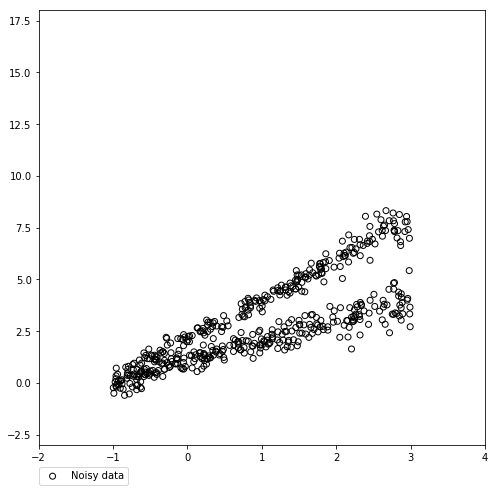

coefficients [2.07634798 1.9408311 ] with probability [0.16296598]
coefficients [2.0678071  1.95223452] with probability [0.16282233]
coefficients [1.02940804 0.86855127] with probability [0.1601467]
coefficients [1.02299939 1.05945515] with probability [0.07965632]
coefficients [1.02180596 1.05217351] with probability [0.07820772]
coefficients [2.19569856 1.62212297] with probability [0.05503092]
coefficients [1.02881204 0.87153997] with probability [0.03897901]
coefficients [0.97884922 1.32373574] with probability [0.03766311]
coefficients [1.55694583 2.3068058 ] with probability [0.03577653]
coefficients [0.98558297 1.30050532] with probability [0.02577973]
coefficients [1.55945809 2.5020223 ] with probability [0.0245103]
coefficients [1.03231507 1.19420627] with probability [0.02221028]
coefficients [1.16534031 0.52829488] with probability [0.0207197]


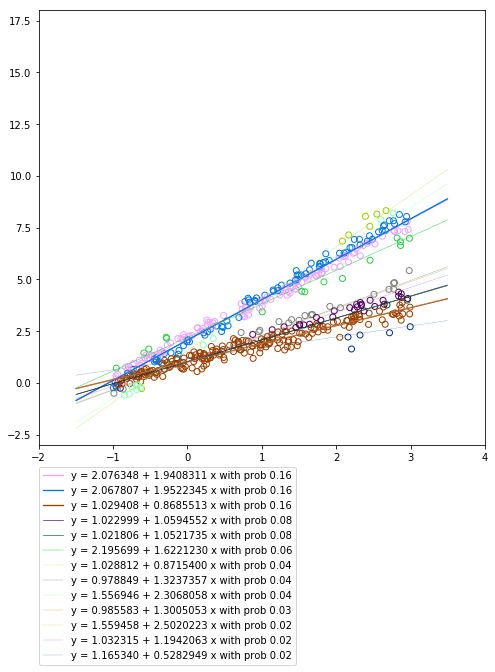

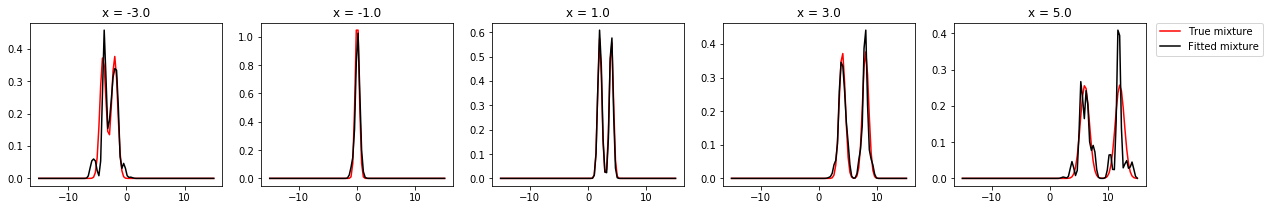

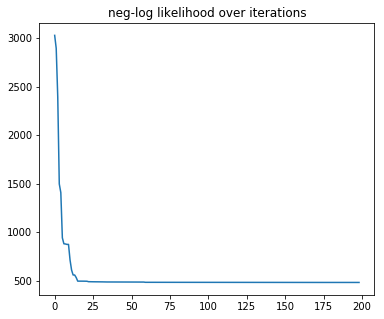

In [9]:
#random initialization for sollmo
test_continuous(500,200,0.5)

In [ ]:
test_continuous(500,30,1)

__Tone perception data__

In [ ]:
#read tonedata into file
with open('tonedata.csv', newline='') as csvfile:
    data = np.array(list(csv.reader(csvfile)))
    data = data[1:]
dataf = data.astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,1],(n,1))), axis = 1)
y = np.reshape(dataf[:,2],(n,1))

In [ ]:
iter = 200
threprob = 0.02

#Use Frank-Wofle with an estimated sigma
sigma = 0.03
f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)


#beta_ols = np.reshape(np.dot(np.matmul(linalg.inv(np.matmul(X.T,X)),X.T),y),(p,1))

In [ ]:
#plot
print("final neg log likelihood is ", L_final)
print("number of components is", len(alpha))
print("only components with probability at least ", threprob, " are shown below:")

fig1 = plt.figure(figsize = (8,8))
plt.scatter(X[:,1],y,color = 'black',marker = 'o',label = 'Noisy data', facecolors = 'None');
t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-6)
#plt.plot(t,b1[0]+b1[1]*t,'r',t,b2[0]+b2[1]*t,'red')
i = 0

index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
for i in index_sorted:
    b = B[:,i]
    if alpha[i] >threprob:
        plt.plot(t,b[0]+b[1]*t, color = str((1-alpha[i][0])/100),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with prob %.2f' %(b[0], b[1], alpha[i]) )
        print("coefficients", b, "with probability", alpha[i])
#plt.plot(t,beta_ols[0]+beta_ols[1]*t,'green')  
#plt.legend(custom_lines, ['Noisy data'#,'True mixture'# 
                         # , 'NPMLE component'#, 'OLS'#
                         #],loc=2);
plt.legend(loc=9, bbox_to_anchor=(1.05, 1),borderaxespad=0.) 
plt.show();

In [ ]:
#define a range of candidate sigma values
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 0.06
sigma_list = np.sqrt(np.arange(sigma_min**2, sigma_max**2, sigma_min**2))

In [ ]:
def L_sigma(X,y,X_test,y_test,sigma_list):
    '''
    test X,y
    '''
    L_sigma_rec = []
    train_error_sigma_rec = []
    test_error_sigma_rec = []
        
    iter = 200
    threprob = 1e-2
    y = np.reshape(y,(len(y),1))
    y_test = np.reshape(y_test,(len(y_test),1))
    
    for sigma in sigma_list:
        f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)
        L_sigma_rec.append(L_final)
        
        beta_ave = np.matmul(B,alpha)
        
        y_train = np.zeros((len(y), 1))
        for i in range(len(y)):
            y_train[i] = np.matmul(X[i],beta_ave)
        y_train = np.reshape(y_train, (len(y),1))
        train_error_sigma_rec.append(linalg.norm(y_train - y)**2/len(X))
        
        y_test_pred = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            y_test_pred[i] = np.matmul(X[i],beta_ave)
        y_test_pred = np.reshape(y_test_pred, (len(y_test),1))
        test_error_sigma_rec.append(linalg.norm(y_test - y_test_pred)**2/len(X))
    
    fig1 = plt.figure(figsize = (6,5))
    plt.plot(sigma_list, L_sigma_rec);
    
    fig2 = plt.figure(figsize = (6,5))
    plt.plot(sigma_list, train_error_sigma_rec);
    
    fig3 = plt.figure(figsize = (6,5))
    plt.plot(sigma_list, test_error_sigma_rec)
    
    return L_sigma_rec,train_error_sigma_rec, test_error_sigma_rec

In [ ]:
#define a range of candidate sigma values
sigma_max = np.sqrt(stats.variance(np.reshape(y, (len(y),))))
sigma_min = 0.03
sigma_list = np.sqrt(np.arange(sigma_min**2, sigma_max**2, 0.06**2))

In [ ]:
subset = np.random.choice(len(y), 10)
L_sigma_rec = L_sigma(X[subset],y[subset],sigma_list)

In [ ]:
number = len(X)
#random permutation to shuffle data
index = np.random.permutation(number)

X_shuffled = X[index]
y_shuffled = y[index]

In [ ]:
L_sigma_rec,train_error_sigma_rec, test_error_sigma_rec = L_sigma(X_shuffled[:40],y_shuffled[:40],X_shuffled[40:50],y_shuffled[40:50],sigma_list)

__5-Fold Cross Validation for Tone Data__

In [ ]:
L_sigma_rec,train_error_sigma_rec, test_error_sigma_rec = L_sigma(X_shuffled[:120],y_shuffled[:120],X_shuffled[120:150],y_shuffled[120:150],sigma_list)

In [ ]:
L_sigma_rec2,train_error_sigma_rec2, test_error_sigma_rec2 = L_sigma(X_shuffled[30:150],y_shuffled[30:150],X_shuffled[:30],y_shuffled[:30],sigma_list)

In [ ]:
L_sigma_rec3,train_error_sigma_rec3, test_error_sigma_rec3 = L_sigma(np.append(X_shuffled[:30], X_shuffled[60:150],axis = 0),np.append(y_shuffled[:30], y_shuffled[60:150],axis = 0),X_shuffled[30:60],y_shuffled[30:60],sigma_list)

In [ ]:
L_sigma_rec4,train_error_sigma_rec4, test_error_sigma_rec4 = L_sigma(np.append(X_shuffled[:60], X_shuffled[90:150],axis = 0),np.append(y_shuffled[:60], y_shuffled[90:150],axis = 0),X_shuffled[60:90],y_shuffled[60:90],sigma_list)

In [ ]:
L_sigma_rec5,train_error_sigma_rec5, test_error_sigma_rec5 = L_sigma(np.append(X_shuffled[:90], X_shuffled[120:150],axis = 0),np.append(y_shuffled[:90], y_shuffled[120:150],axis = 0),X_shuffled[90:120],y_shuffled[90:120],sigma_list)

In [ ]:
L_sigma_rec_CV = np.zeros((len(sigma_list),1))
L_sigma_rec_CV = np.array(L_sigma_rec)+np.array(L_sigma_rec2)+ np.array(L_sigma_rec3)+ np.array(L_sigma_rec4)+ np.array(L_sigma_rec5)

In [ ]:
train_error_sigma_rec_CV = np.zeros((len(sigma_list),1))
train_error_sigma_rec_CV = np.array(train_error_sigma_rec) + np.array(train_error_sigma_rec2) + np.array(train_error_sigma_rec3) + np.array(train_error_sigma_rec4) + np.array(train_error_sigma_rec5)
train_error_sigma_rec_CV = train_error_sigma_rec_CV/5

In [ ]:
fig1 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, L_sigma_rec_CV);plt.title("5-fold CV neg-log likelihood");
    
fig2 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, train_error_sigma_rec_CV);plt.title("5-fold CV taining error");
    
fig3 = plt.figure(figsize = (6,5))
plt.plot(sigma_list, test_error_sigma_rec_CV);plt.title("5-fold CV validation error");

__GDP-CO2 Data__

In [ ]:
#read gdp-co2data into file
with open('gdp-co2.csv', newline='') as csvfile:
    data = np.array(list(csv.reader(csvfile)))
dataf = data[:,1:4].astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,1]/dataf[:,0]*100,(n,1))), axis = 1)
y = np.reshape(dataf[:,2]/dataf[:,0]*1e+6,(n,1))

In [ ]:
iter = 200
threprob = 1e-2

#Use Frank-Wofle with an estimated sigma
sigma = 2
f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)

##########IMPORTANT subproblem initializes with beta = 0


In [ ]:
#plot
print("final neg log likelihood is ", L_final)
print("number of components is", len(alpha))
print("only components with probability at least ", threprob, " are shown below:")

fig1 = plt.figure(figsize = (8,8))
plt.scatter(X[:,1],y,color = 'blue',marker = 'o',label = 'Noisy data', facecolors = 'None');
t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-2)
i = 0
for i in range(len(alpha)):
    b = B[:,i]
    if alpha[i] >threprob:
        plt.plot(t,b[0]+b[1]*t, color = str((1-alpha[i][0])/100),linewidth = alpha[i][0]*8 )
        print("coefficients", b, "with probability", alpha[i]) 
custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                Line2D([0], [0], color='black')
                ,]
plt.legend(custom_lines, ['Noisy data'
                          , 'NPMLE component'
                         ],loc=9);
plt.show();

__Aphids Data__

In [ ]:
#read aphids into file
with open('aphids.csv', newline='') as csvfile:
    data = np.array(list(csv.reader(csvfile)))
dataf = data[1:,1:3].astype(np.float)
n = np.shape(dataf)[0]
ones = np.ones((n,1))
X = np.concatenate((ones, np.reshape(dataf[:,0],(n,1))), axis = 1)
y = np.reshape(dataf[:,1],(n,1))

In [ ]:
def test_aphids(sigma):
    iter = 200
    #Use Frank-Wofle with an estimated sigma
    #sigma = 3.3
    f, B, alpha, L_rec, L_final = NPMLE_FW(X,y,iter,sigma)
    threprob = 0.02
    #plot
    print("final neg log likelihood is ", L_final)
    print("number of components is", len(alpha))
    print("only components with probability at least ", threprob, " are shown below:")

    fig1 = plt.figure(figsize = (8,8))
    plt.scatter(X[:,1],y,color = 'blue',marker = 'o',label = 'Noisy data', facecolors = 'None');
    t = np.arange(np.amin(X[:,1])-0.5,np.amax(X[:,1])+0.5,1e-2)
    i = 0
    index_sorted = np.argsort(-np.reshape(alpha,(len(alpha),)))
    for i in index_sorted:
        b = B[:,i]
        if alpha[i] >threprob:
            plt.plot(t,b[0]+b[1]*t, color = str((1-alpha[i][0])/100),linewidth = alpha[i][0]*8 ,label = 'y = %.4f + %.4f x with prob %.2f' %(b[0], b[1], alpha[i]) )
            print("coefficients", b, "with probability", alpha[i]) 
    custom_lines = [Line2D([], [], color='blue', marker='o',markerfacecolor = 'None', linestyle='None'),
                    Line2D([0], [0], color='black')
                    ,]
    #plt.legend(custom_lines, ['Noisy data'
                 #             , 'NPMLE component'
                  #           ],loc=0);
    plt.legend(loc=9, bbox_to_anchor=(1.05, 1),borderaxespad=0.) 
    plt.show();

In [ ]:
for sigma in np.arange(1,3,0.1):
    print("**************************",sigma)
    test_aphids(sigma)